In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
teis_p = pd.read_csv('../data/teis_p.csv')
teis_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96580 entries, 0 to 96579
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   POE                        96580 non-null  object
 1   Child ID                   96580 non-null  int64 
 2   DOB                        96580 non-null  object
 3   County Name                96576 non-null  object
 4   County SES                 96576 non-null  object
 5   Child Phase                96580 non-null  object
 6   Active                     96580 non-null  object
 7   Service Coordinator        96579 non-null  object
 8   Notification Date          96580 non-null  object
 9   Parent Consent Date        70026 non-null  object
 10  Referral Source Type Name  96580 non-null  object
 11  Initial Eligibility        68221 non-null  object
 12  Initial Eligibility Date   68221 non-null  object
 13  Initial IFSP Date          45493 non-null  object
 14  Latest

In [3]:
teis_c = pd.read_csv('../data/teis_c.csv')
teis_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113256 entries, 0 to 113255
Data columns (total 34 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   POE                          113256 non-null  object 
 1   Child ID                     113256 non-null  int64  
 2   DOB                          113256 non-null  object 
 3   County Name                  113251 non-null  object 
 4   County SES                   113251 non-null  object 
 5   Child Phase                  113256 non-null  object 
 6   Active                       113256 non-null  object 
 7   Service Coordinator          113255 non-null  object 
 8   Notification/ Referral Date  113256 non-null  object 
 9   Parent Consent Date          58101 non-null   object 
 10  Referral Source Type Name    113256 non-null  object 
 11  Initial Eligibility          40762 non-null   object 
 12  Initial Eligibility Date     40762 non-null   object 
 13 

In [4]:
teis_c = teis_c.rename(columns = {'Notification/ Referral Date' : 'Notification Date'})
teis_p = teis_p.rename(columns = {'County SES ' : 'County SES'})

The next group of cells is experimenting with different ways of joining the two datasets, looking at duplicates, etc.

In [5]:
teis_merge = pd.merge(teis_c, teis_p, how='outer')
teis_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 191578 entries, 0 to 191577
Data columns (total 34 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   POE                          191578 non-null  object 
 1   Child ID                     191578 non-null  int64  
 2   DOB                          191578 non-null  object 
 3   County Name                  191570 non-null  object 
 4   County SES                   191570 non-null  object 
 5   Child Phase                  191578 non-null  object 
 6   Active                       191578 non-null  object 
 7   Service Coordinator          191577 non-null  object 
 8   Notification Date            191578 non-null  object 
 9   Parent Consent Date          127024 non-null  object 
 10  Referral Source Type Name    191578 non-null  object 
 11  Initial Eligibility          107265 non-null  object 
 12  Initial Eligibility Date     107265 non-null  object 
 13 

In [6]:
full_teis= pd.concat([teis_c, teis_p])

In [7]:
teis_clean = full_teis[~full_teis.duplicated(['POE', 'Child ID', 'DOB', 'County Name', 'County SES', 'Child Phase',
       'Active', 'Service Coordinator', 'Notification Date',
       'Parent Consent Date', 'Referral Source Type Name',
       'Initial Eligibility', 'Initial Eligibility Date', 'Initial IFSP Date',
       'Latest IFSP Date', 'Exit Reason', 'Exit Date'])]
teis_clean.info()
#pulling out rows that are the same across all columns that the two dataframes share

<class 'pandas.core.frame.DataFrame'>
Int64Index: 191578 entries, 0 to 96579
Data columns (total 34 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   POE                          191578 non-null  object 
 1   Child ID                     191578 non-null  int64  
 2   DOB                          191578 non-null  object 
 3   County Name                  191570 non-null  object 
 4   County SES                   191570 non-null  object 
 5   Child Phase                  191578 non-null  object 
 6   Active                       191578 non-null  object 
 7   Service Coordinator          191577 non-null  object 
 8   Notification Date            191578 non-null  object 
 9   Parent Consent Date          127024 non-null  object 
 10  Referral Source Type Name    191578 non-null  object 
 11  Initial Eligibility          107265 non-null  object 
 12  Initial Eligibility Date     107265 non-null  object 
 13  

In [8]:
import re
from tqdm.notebook import tqdm

In [9]:
for ind, row in tqdm(teis_clean.iterrows()):
    if re.search('\d{5}', str(row['Exit Date'])):
        teis_clean.loc[ind, 'Exit Date'] = np.NaN
#this is clearing out the weird data that's in the 'Exit Date' column

0it [00:00, ?it/s]

In [10]:
teis_clean[['DOB', 'Notification Date', 'Parent Consent Date', 'third DOB', 'Exit Date']] = teis_clean[['DOB', 'Notification Date', 'Parent Consent Date', 'third DOB', 'Exit Date']].apply(pd.to_datetime)
teis_clean

C:\Users\mews2\AppData\Local\Temp\ipykernel_6080\1059363929.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  teis_clean[['DOB', 'Notification Date', 'Parent Consent Date', 'third DOB', 'Exit Date']] = teis_clean[['DOB', 'Notification Date', 'Parent Consent Date', 'third DOB', 'Exit Date']].apply(pd.to_datetime)


,POE,Child ID,DOB,County Name,County SES,Child Phase,Active,Service Coordinator,Notification Date,Parent Consent Date,...,Service Coordinator Counter,Fiscal Year.1,Child Count,2012 Child Count,2013 Child Count,third DOB,Late Referral,Qtr,QTR,Referral Source Category
0,ET,403339,2014-08-09,Blount,Transitional,Eligibility,A,Kristi Borer,2016-07-01,2016-07-01,...,1.0,2016.0,1.0,NaN,NaN,2017-08-09,NaN,1.0,Qtr 1,#REF!
1,FT,404085,2013-07-31,Unicoi,At-Risk,Notification,I,Jennifer Terranera - 45 days,2016-07-01,NaT,...,1.0,2016.0,1.0,NaN,NaN,2016-07-31,1.0,1.0,Qtr 1,#REF!
2,FT,403623,2016-02-05,Sullivan,Transitional,Eligibility,A,Amy Talbert,2016-07-01,2016-07-20,...,1.0,2016.0,1.0,NaN,NaN,2019-02-05,NaN,1.0,Qtr 1,#REF!
3,FT,404157,2015-12-06,Sullivan,Transitional,IFSP,A,Candice Cradic,2016-07-01,2016-07-22,...,1.0,2016.0,1.0,NaN,NaN,2018-12-06,NaN,1.0,Qtr 1,#REF!
4,FT,404154,2015-04-18,Hawkins,At-Risk,IFSP,A,Kathy Jeffries,2016-07-01,2016-07-18,...,1.0,2016.0,1.0,NaN,NaN,2018-04-18,NaN,1.0,Qtr 1,#REF!
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96572,UC,523485,2019-10-23,Sumner,Competitive,IFSP,A,Miriam Espinosa,2022-03-02,2022-03-10,...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
96573,UC,528430,2022-01-05,Cumberland,Transitional,IFSP,A,Lisa Davis,2022-05-10,2022-05-18,...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
96574,UC,515685,2019-08-14,Sumner,Competitive,IFSP,A,Cindy Willard,2021-12-01,2021-12-07,...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
96577,UC,525460,2019-08-27,Sumner,Competitive,Notification,I,Sherry Roberts-DS,2022-03-29,NaT,...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN


In [11]:
teis_clean = teis_clean.drop(columns = ['2012 Child Count', '2013 Child Count', 'Service Coordinator Counter', 'Referral Count',
                                        'Evaluation Count', 'Eligibility Count', 'IFSP Count', 'Child Count', ' QTR ', 
                                       'Referral Source Category'])
teis_clean.head(2)
#there isn't meaningful data in these columns (at least not for the purposes of this project)

,POE,Child ID,DOB,County Name,County SES,Child Phase,Active,Service Coordinator,Notification Date,Parent Consent Date,...,Latest IFSP Date,Exit Reason,Exit Date,Fiscal Year,Notification Month,Tenn Region,Fiscal Year.1,third DOB,Late Referral,Qtr
0,ET,403339,2014-08-09,Blount,Transitional,Eligibility,A,Kristi Borer,2016-07-01,2016-07-01,...,NaN,NaN,NaT,2016-2017,Jul,Eastern,2016.0,2017-08-09,NaN,1.0
1,FT,404085,2013-07-31,Unicoi,At-Risk,Notification,I,Jennifer Terranera - 45 days,2016-07-01,NaT,...,NaN,Referral less than 45 days,2016-07-01,2016-2017,Jul,Eastern,2016.0,2016-07-31,1.0,1.0


In [12]:
all_teis_dups = teis_clean[teis_clean.duplicated(['Child ID', 'Notification Date'], keep=False)].sort_values('Child ID')
all_teis_dups
#pulling all rows that have 'Child ID' and 'Notification Date' in common to take a look

,POE,Child ID,DOB,County Name,County SES,Child Phase,Active,Service Coordinator,Notification Date,Parent Consent Date,...,Latest IFSP Date,Exit Reason,Exit Date,Fiscal Year,Notification Month,Tenn Region,Fiscal Year.1,third DOB,Late Referral,Qtr
437,NW,351755,2013-11-13,Madison,Transitional,Evaluation,A,Rene Bard,2016-07-12,2016-07-12,...,NaN,NaN,NaT,2016-2017,Jul,Western,2016.0,2016-11-13,NaN,1.0
8367,NW,351755,2013-11-13,Madison,Transitional,Eligibility,I,Rene Bard,2016-07-12,2016-07-12,...,NaN,Ineligible for Part C,2016-08-25,NaN,NaN,NaN,NaN,NaT,NaN,NaN
13240,UC,353805,2013-12-04,Putnam,Transitional,IFSP,I,Anna Bolin,2016-08-05,2016-08-15,...,NaN,618 - Part B eligibility not determined,2016-12-03,NaN,NaN,NaN,NaN,NaT,NaN,NaN
1552,UC,353805,2013-12-04,Putnam,Transitional,Evaluation,A,Anna Bolin,2016-08-05,2016-08-15,...,NaN,NaN,NaT,2016-2017,Aug,Middle,2016.0,2016-12-04,NaN,1.0
4142,MD,353900,2013-10-09,Shelby,Transitional,Notification,I,JoAnn Hinkle-DA,2016-09-29,NaT,...,NaN,Referral less than 45 days,2016-09-29,2016-2017,Sep,Western,2016.0,2016-10-09,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95952,UC,529587,2022-03-15,Sumner,Competitive,Eligibility,I,Sherry Roberts-DS,2022-05-31,2022-06-08,...,NaN,Ineligible for Part C,2022-06-24,NaN,NaN,NaN,NaN,NaT,NaN,NaN
93343,SE,529597,2020-04-10,McMinn,Transitional,Eligibility,I,Jennifer Rose - ES,2022-05-31,2022-06-04,...,NaN,Ineligible for Part C,2022-06-27,NaN,NaN,NaN,NaN,NaT,NaN,NaN
112947,SE,529597,2020-04-10,McMinn,Transitional,Notification,A,Signal Centers-EEA,2022-05-31,NaT,...,NaN,NaN,NaT,2021-2022,May,Eastern,2021.0,2023-04-10,NaN,4.0
81090,FT,529609,2020-05-13,Washington,Transitional,Notification,I,Alicia Taylor - Admin,2022-05-31,NaT,...,NaN,Unable to contact,2022-07-01,NaN,NaN,NaN,NaN,NaT,NaN,NaN


In [13]:
num_all_dup = len(np.unique(np.array(all_teis_dups['Child ID'])))
num_all_dup

76054

In [14]:
county_dups = all_teis_dups[~all_teis_dups.duplicated(['County Name', 'Child ID', 'Notification Date'], keep=False)]
county_dups
#These are instances when the same referral was noted under 2 different counties

,POE,Child ID,DOB,County Name,County SES,Child Phase,Active,Service Coordinator,Notification Date,Parent Consent Date,...,Latest IFSP Date,Exit Reason,Exit Date,Fiscal Year,Notification Month,Tenn Region,Fiscal Year.1,third DOB,Late Referral,Qtr
9221,SC,360673,2014-02-19,Rutherford,Competitive,IFSP,I,LaKika King,2016-09-08,2016-09-16,...,2/6/2017,618 - Part B eligible,2017-02-18,NaN,NaN,NaN,NaN,NaT,NaN,NaN
3088,GN,360673,2014-02-19,Davidson,Competitive,Eligibility,A,Dalmys Sanchez,2016-09-08,2016-09-16,...,NaN,NaN,NaT,2016-2017,Sep,Middle,2016.0,2017-02-19,NaN,1.0
3729,ET,365886,2014-02-28,Blount,Transitional,IFSP,A,Karen Stock,2016-09-21,NaT,...,9/26/2016,NaN,NaT,2016-2017,Sep,Eastern,2016.0,2017-02-28,NaN,1.0
285,ET,365886,2014-02-28,Knox,Transitional,IFSP,I,Karen Stock,2016-09-21,2016-09-22,...,2/3/2017,618 - Part B eligibility not determined,2017-02-27,NaN,NaN,NaN,NaN,NaT,NaN,NaN
66,FT,381125,2014-09-26,Washington,Transitional,Eligibility,A,Melinda Sutton,2016-07-05,2016-07-25,...,NaN,NaN,NaT,2016-2017,Jul,Eastern,2016.0,2017-09-26,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81300,FT,528738,2021-09-22,Unicoi,At-Risk,IFSP,A,Sarah McKinney,2022-05-16,2022-05-25,...,6/27/2022,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaN,NaN
111795,FT,528739,2021-09-22,Washington,Transitional,Eligibility,A,Melinda Burrell,2022-05-16,2022-05-25,...,NaN,NaN,NaT,2021-2022,May,Eastern,2021.0,2024-09-22,NaN,4.0
81287,FT,528739,2021-09-22,Unicoi,At-Risk,IFSP,A,Sarah McKinney,2022-05-16,2022-05-25,...,6/27/2022,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaN,NaN
92411,SE,529465,2020-11-11,Bradley,Transitional,Eligibility,A,Jennifer Steward,2022-05-27,2022-05-31,...,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaN,NaN


In [15]:
num_county_dup = len(np.unique(np.array(county_dups['Child ID'])))
num_county_dup

3168

In [16]:
POE_dups = all_teis_dups[~all_teis_dups.duplicated(['POE', 'Child ID', 'Notification Date'], keep=False)]
POE_dups
#These are instances when the same referral was noted under 2 different POEs

,POE,Child ID,DOB,County Name,County SES,Child Phase,Active,Service Coordinator,Notification Date,Parent Consent Date,...,Latest IFSP Date,Exit Reason,Exit Date,Fiscal Year,Notification Month,Tenn Region,Fiscal Year.1,third DOB,Late Referral,Qtr
9221,SC,360673,2014-02-19,Rutherford,Competitive,IFSP,I,LaKika King,2016-09-08,2016-09-16,...,2/6/2017,618 - Part B eligible,2017-02-18,NaN,NaN,NaN,NaN,NaT,NaN,NaN
3088,GN,360673,2014-02-19,Davidson,Competitive,Eligibility,A,Dalmys Sanchez,2016-09-08,2016-09-16,...,NaN,NaN,NaT,2016-2017,Sep,Middle,2016.0,2017-02-19,NaN,1.0
769,ET,382571,2014-11-05,Sevier,Transitional,IFSP,I,Tonia Hodsden,2016-09-22,2016-09-22,...,4/11/2017,618 - Parent withdraw,2017-09-21,NaN,NaN,NaN,NaN,NaT,NaN,NaN
3810,FT,382571,2014-11-05,Cocke,Distressed,Eligibility,A,Barbara Bowman,2016-09-22,2016-09-22,...,NaN,NaN,NaT,2016-2017,Sep,Eastern,2016.0,2017-11-05,NaN,1.0
2435,SW,385467,2015-01-31,Fayette,Transitional,Eligibility,A,Yalunda Whiteside,2016-08-24,2016-09-01,...,NaN,NaN,NaT,2016-2017,Aug,Western,2016.0,2018-01-31,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81455,FT,526514,2021-01-07,Hamblen,Transitional,IFSP,A,Averi Parker,2022-04-11,2022-04-27,...,5/18/2022,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaN,NaN
95224,UC,527542,2020-10-07,Sumner,Competitive,IFSP,A,Taylor Lee,2022-04-26,2022-05-03,...,5/11/2022,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaN,NaN
110110,GN,527542,2020-10-07,Robertson,Transitional,Eligibility,A,Taylor Watson,2022-04-26,2022-05-03,...,NaN,NaN,NaT,2021-2022,Apr,Middle,2021.0,2023-10-07,NaN,4.0
111939,GN,529308,2020-06-01,Marshall,Transitional,Evaluation,A,Kim Correll,2022-05-25,2022-06-07,...,NaN,NaN,NaT,2021-2022,May,Middle,2021.0,2023-06-01,NaN,4.0


In [17]:
county_status_dups = county_dups[county_dups.duplicated(['Child ID', 'Child Phase', 'Notification Date'], keep=False)]
county_status_dups
#looking at the duplicates that have different counties but the same status

,POE,Child ID,DOB,County Name,County SES,Child Phase,Active,Service Coordinator,Notification Date,Parent Consent Date,...,Latest IFSP Date,Exit Reason,Exit Date,Fiscal Year,Notification Month,Tenn Region,Fiscal Year.1,third DOB,Late Referral,Qtr
3729,ET,365886,2014-02-28,Blount,Transitional,IFSP,A,Karen Stock,2016-09-21,NaT,...,9/26/2016,NaN,NaT,2016-2017,Sep,Eastern,2016.0,2017-02-28,NaN,1.0
285,ET,365886,2014-02-28,Knox,Transitional,IFSP,I,Karen Stock,2016-09-21,2016-09-22,...,2/3/2017,618 - Part B eligibility not determined,2017-02-27,NaN,NaN,NaN,NaN,NaT,NaN,NaN
12365,UC,385283,2015-01-31,Putnam,Transitional,IFSP,I,Kim Pierce,2017-04-25,2017-05-02,...,10/30/2017,618 - Part B eligibility not determined,2018-01-30,NaN,NaN,NaN,NaN,NaT,NaN,NaN
13302,UC,385283,2015-01-31,Overton,Transitional,IFSP,A,Kim Pierce,2017-04-25,2017-05-02,...,5/2/2017,NaN,NaT,2016-2017,Apr,Middle,2016.0,2018-01-31,NaN,4.0
12971,UC,386507,2014-10-24,Sumner,Competitive,IFSP,I,Miriam Espinosa,2016-11-01,2016-11-30,...,6/15/2017,618 - Parent withdraw,2017-09-13,NaN,NaN,NaN,NaN,NaT,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107545,ET,523720,2021-01-05,Knox,Transitional,IFSP,A,Kristi Hopwood,2022-03-07,2022-03-08,...,4/6/2022,NaN,NaT,2021-2022,Mar,Eastern,2021.0,2024-01-05,NaN,3.0
80374,ET,524519,2021-12-28,Monroe,At-Risk,Eligibility,I,Leslie Milligan,2022-03-15,2022-03-21,...,NaN,Unable to contact,2022-05-31,NaN,NaN,NaN,NaN,NaT,NaN,NaN
109200,SE,524519,2021-12-28,Bradley,Transitional,Eligibility,A,Jaci Robertson,2022-03-15,2022-03-21,...,NaN,NaN,NaT,2021-2022,Mar,Eastern,2021.0,2024-12-28,NaN,3.0
109557,ET,526317,2021-03-21,Sevier,Transitional,Eligibility,A,Cynthia Miller,2022-04-07,2022-04-13,...,NaN,NaN,NaT,2021-2022,Apr,Eastern,2021.0,2024-03-21,NaN,4.0


In [18]:
teis_c[teis_c.duplicated(['Child ID', 'Notification Date'], keep=False)]
#reconfirming that this original dataframe doesn't have any rows that have the same Child ID and Notification Date

,POE,Child ID,DOB,County Name,County SES,Child Phase,Active,Service Coordinator,Notification Date,Parent Consent Date,...,Service Coordinator Counter,Fiscal Year.1,Child Count,2012 Child Count,2013 Child Count,third DOB,Late Referral,Qtr,QTR,Referral Source Category


#### Notes on our decisions regarding how to most effectively merge our data
After exploring the duplicate data, we decided to drop all columns from the teis_c dataframe that it shares with the teis_p dataframe except for Child ID and Notification Date. This will allow us to merge without creating any duplicates, keep the "extra" columns in teis_c, and per the folks at TEIS, the data from the teis_p dataframe should supercede any from the teis_c dataframe because it is more current

In [19]:
teis_c2 = teis_c.drop(columns = ['POE', 'DOB', 'County Name', 'County SES', 'Child Phase', 'Active', 'Service Coordinator', 
                                 'Parent Consent Date', 'Referral Source Type Name', 'Initial Eligibility', 'Initial Eligibility Date', 'Initial IFSP Date', 'Latest IFSP Date', 'Exit Reason', 'Exit Date',
                                 '2012 Child Count', '2013 Child Count', 'Service Coordinator Counter', 'Referral Count', 
                                 'Evaluation Count', 'Eligibility Count', 'IFSP Count', 'Child Count', ' QTR ', 
                                 'Referral Source Category'])
teis_c2

,Child ID,Notification Date,Fiscal Year,Notification Month,Tenn Region,Fiscal Year.1,third DOB,Late Referral,Qtr
0,403339,7/1/2016,2016-2017,Jul,Eastern,2016,8/9/2017,NaN,1
1,404085,7/1/2016,2016-2017,Jul,Eastern,2016,7/31/2016,1.0,1
2,403623,7/1/2016,2016-2017,Jul,Eastern,2016,2/5/2019,NaN,1
3,404157,7/1/2016,2016-2017,Jul,Eastern,2016,12/6/2018,NaN,1
4,404154,7/1/2016,2016-2017,Jul,Eastern,2016,4/18/2018,NaN,1
...,...,...,...,...,...,...,...,...,...
113251,528759,5/16/2022,2021-2022,May,Middle,2021,4/7/2024,NaN,4
113252,528534,5/11/2022,2021-2022,May,Middle,2021,3/13/2025,NaN,4
113253,528430,5/10/2022,2021-2022,May,Middle,2021,1/5/2025,NaN,4
113254,528253,5/6/2022,2021-2022,May,Middle,2021,9/12/2023,NaN,4


In [20]:
teis_merge3 = pd.merge(teis_c2, teis_p, how='outer').sort_values(['Child ID'])
teis_merge3

,Child ID,Notification Date,Fiscal Year,Notification Month,Tenn Region,Fiscal Year.1,third DOB,Late Referral,Qtr,POE,...,Active,Service Coordinator,Parent Consent Date,Referral Source Type Name,Initial Eligibility,Initial Eligibility Date,Initial IFSP Date,Latest IFSP Date,Exit Reason,Exit Date
25415,104085,1/20/2018,2017-2018,Jan,Middle,2017.0,7/7/2010,1.0,3.0,GN,...,I,NaN,NaN,DCS,NaN,NaN,NaN,NaN,Unable to contact,1/25/2010
2092,350065,8/17/2016,2016-2017,Aug,Middle,2016.0,10/15/2016,1.0,1.0,UC,...,I,Steven Scarlett,NaN,PCP,NaN,NaN,NaN,NaN,Unable to contact,8/31/2016
437,351755,7/12/2016,2016-2017,Jul,Western,2016.0,11/13/2016,NaN,1.0,NW,...,I,Rene Bard,7/12/2016,Parent,Ineligible,8/25/2016,NaN,NaN,Ineligible for Part C,8/25/2016
3369,353800,9/14/2016,2016-2017,Sep,Eastern,2016.0,10/1/2016,1.0,1.0,FT,...,I,Jennifer Terranera - 45 days,NaN,Parent,NaN,NaN,NaN,NaN,Referral less than 45 days,9/15/2016
1552,353805,8/5/2016,2016-2017,Aug,Middle,2016.0,12/4/2016,NaN,1.0,UC,...,I,Anna Bolin,8/15/2016,Dept. of Health,Eligible,10/5/2016,10/10/2016,NaN,618 - Part B eligibility not determined,12/3/2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114109,531592,7/1/2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GN,...,A,Kim Correll,NaN,PCP,NaN,NaN,NaN,NaN,NaN,NaN
114352,531593,7/1/2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GN,...,A,Kim Correll,NaN,PCP,NaN,NaN,NaN,NaN,NaN,NaN
114075,531594,7/1/2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GN,...,A,Kim Correll,NaN,Other Health Care Provider,NaN,NaN,NaN,NaN,NaN,NaN
114046,531595,7/1/2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GN,...,A,Kim Correll,NaN,Hospital,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
teis_merge3[['DOB', 'Notification Date', 'Parent Consent Date', 'third DOB', 'Exit Date']] = teis_merge3[['DOB', 'Notification Date', 'Parent Consent Date', 'third DOB', 'Exit Date']].apply(pd.to_datetime)
teis_merge3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115524 entries, 25415 to 114959
Data columns (total 24 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Child ID                   115524 non-null  int64         
 1   Notification Date          115524 non-null  datetime64[ns]
 2   Fiscal Year                113256 non-null  object        
 3   Notification Month         113256 non-null  object        
 4   Tenn Region                113256 non-null  object        
 5   Fiscal Year.1              113256 non-null  float64       
 6   third DOB                  113256 non-null  datetime64[ns]
 7   Late Referral              2829 non-null    float64       
 8   Qtr                        113256 non-null  float64       
 9   POE                        96580 non-null   object        
 10  DOB                        96580 non-null   datetime64[ns]
 11  County Name                96576 non-null   obje

In [22]:
teis_c3 = teis_c.drop(columns = ['2012 Child Count', '2013 Child Count', 'Service Coordinator Counter', 'Referral Count', 
                                 'Evaluation Count', 'Eligibility Count', 'IFSP Count', 'Child Count', ' QTR ', 
                                 'Referral Source Category'])
teis_c3

,POE,Child ID,DOB,County Name,County SES,Child Phase,Active,Service Coordinator,Notification Date,Parent Consent Date,...,Latest IFSP Date,Exit Reason,Exit Date,Fiscal Year,Notification Month,Tenn Region,Fiscal Year.1,third DOB,Late Referral,Qtr
0,ET,403339,8/9/2014,Blount,Transitional,Eligibility,A,Kristi Borer,7/1/2016,7/1/16,...,NaN,NaN,NaN,2016-2017,Jul,Eastern,2016,8/9/2017,NaN,1
1,FT,404085,7/31/2013,Unicoi,At-Risk,Notification,I,Jennifer Terranera - 45 days,7/1/2016,NaN,...,NaN,Referral less than 45 days,7/1/2016,2016-2017,Jul,Eastern,2016,7/31/2016,1.0,1
2,FT,403623,2/5/2016,Sullivan,Transitional,Eligibility,A,Amy Talbert,7/1/2016,7/20/16,...,NaN,NaN,NaN,2016-2017,Jul,Eastern,2016,2/5/2019,NaN,1
3,FT,404157,12/6/2015,Sullivan,Transitional,IFSP,A,Candice Cradic,7/1/2016,7/22/16,...,8/10/2016,NaN,NaN,2016-2017,Jul,Eastern,2016,12/6/2018,NaN,1
4,FT,404154,4/18/2015,Hawkins,At-Risk,IFSP,A,Kathy Jeffries,7/1/2016,7/18/16,...,7/28/2016,NaN,NaN,2016-2017,Jul,Eastern,2016,4/18/2018,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113251,UC,528759,4/7/2021,Sumner,Competitive,Evaluation,A,Sherry Roberts-DS,5/16/2022,5/26/2022,...,NaN,NaN,NaN,2021-2022,May,Middle,2021,4/7/2024,NaN,4
113252,UC,528534,3/13/2022,Sumner,Competitive,IFSP,A,Robyn Hogan,5/11/2022,5/23/2022,...,6/14/2022,NaN,NaN,2021-2022,May,Middle,2021,3/13/2025,NaN,4
113253,UC,528430,1/5/2022,Cumberland,Transitional,Eligibility,A,Lisa Davis,5/10/2022,5/18/2022,...,NaN,NaN,NaN,2021-2022,May,Middle,2021,1/5/2025,NaN,4
113254,UC,528253,9/12/2020,Sumner,Competitive,IFSP,A,Taylor Lee,5/6/2022,5/11/2022,...,5/31/2022,NaN,NaN,2021-2022,May,Middle,2021,9/12/2023,NaN,4


In [23]:
for ind, row in tqdm(teis_c3.iterrows()):
    if re.search('\d{5}', str(row['Exit Date'])):
        teis_c3.loc[ind, 'Exit Date'] = np.NaN

0it [00:00, ?it/s]

In [24]:
teis_c3[['DOB', 'Notification Date', 'Parent Consent Date', 'third DOB', 'Exit Date']] = teis_c3[['DOB', 'Notification Date', 'Parent Consent Date', 'third DOB', 'Exit Date']].apply(pd.to_datetime)
teis_c3

,POE,Child ID,DOB,County Name,County SES,Child Phase,Active,Service Coordinator,Notification Date,Parent Consent Date,...,Latest IFSP Date,Exit Reason,Exit Date,Fiscal Year,Notification Month,Tenn Region,Fiscal Year.1,third DOB,Late Referral,Qtr
0,ET,403339,2014-08-09,Blount,Transitional,Eligibility,A,Kristi Borer,2016-07-01,2016-07-01,...,NaN,NaN,NaT,2016-2017,Jul,Eastern,2016,2017-08-09,NaN,1
1,FT,404085,2013-07-31,Unicoi,At-Risk,Notification,I,Jennifer Terranera - 45 days,2016-07-01,NaT,...,NaN,Referral less than 45 days,2016-07-01,2016-2017,Jul,Eastern,2016,2016-07-31,1.0,1
2,FT,403623,2016-02-05,Sullivan,Transitional,Eligibility,A,Amy Talbert,2016-07-01,2016-07-20,...,NaN,NaN,NaT,2016-2017,Jul,Eastern,2016,2019-02-05,NaN,1
3,FT,404157,2015-12-06,Sullivan,Transitional,IFSP,A,Candice Cradic,2016-07-01,2016-07-22,...,8/10/2016,NaN,NaT,2016-2017,Jul,Eastern,2016,2018-12-06,NaN,1
4,FT,404154,2015-04-18,Hawkins,At-Risk,IFSP,A,Kathy Jeffries,2016-07-01,2016-07-18,...,7/28/2016,NaN,NaT,2016-2017,Jul,Eastern,2016,2018-04-18,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113251,UC,528759,2021-04-07,Sumner,Competitive,Evaluation,A,Sherry Roberts-DS,2022-05-16,2022-05-26,...,NaN,NaN,NaT,2021-2022,May,Middle,2021,2024-04-07,NaN,4
113252,UC,528534,2022-03-13,Sumner,Competitive,IFSP,A,Robyn Hogan,2022-05-11,2022-05-23,...,6/14/2022,NaN,NaT,2021-2022,May,Middle,2021,2025-03-13,NaN,4
113253,UC,528430,2022-01-05,Cumberland,Transitional,Eligibility,A,Lisa Davis,2022-05-10,2022-05-18,...,NaN,NaN,NaT,2021-2022,May,Middle,2021,2025-01-05,NaN,4
113254,UC,528253,2020-09-12,Sumner,Competitive,IFSP,A,Taylor Lee,2022-05-06,2022-05-11,...,5/31/2022,NaN,NaT,2021-2022,May,Middle,2021,2023-09-12,NaN,4


In [25]:
teis_merge2 = pd.merge(teis_merge3, teis_c3, on=['Child ID', 'Notification Date'], how='left')
teis_merge2.info()
##Need to do this to bring back in the data for the rows in our merge that were present only in teis_c

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115524 entries, 0 to 115523
Data columns (total 46 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   Child ID                     115524 non-null  int64         
 1   Notification Date            115524 non-null  datetime64[ns]
 2   Fiscal Year_x                113256 non-null  object        
 3   Notification Month_x         113256 non-null  object        
 4   Tenn Region_x                113256 non-null  object        
 5   Fiscal Year.1_x              113256 non-null  float64       
 6   third DOB_x                  113256 non-null  datetime64[ns]
 7   Late Referral_x              2829 non-null    float64       
 8   Qtr_x                        113256 non-null  float64       
 9   POE_x                        96580 non-null   object        
 10  DOB_x                        96580 non-null   datetime64[ns]
 11  County Name_x             

In [26]:
teis_merge2['Referral Source Type Name_x'] = teis_merge2['Referral Source Type Name_x'].fillna(teis_merge2['Referral Source Type Name_y'])
teis_merge2['Late Referral_x'] = teis_merge2['Late Referral_x'].fillna(teis_merge2['Late Referral_y'])
teis_merge2['Qtr_x'] = teis_merge2['Qtr_x'].fillna(teis_merge2['Qtr_y'])
teis_merge2['POE_x'] = teis_merge2['POE_x'].fillna(teis_merge2['POE_y'])
teis_merge2['DOB_x'] = teis_merge2['DOB_x'].fillna(teis_merge2['DOB_y'])
teis_merge2['County Name_x'] = teis_merge2['County Name_x'].fillna(teis_merge2['County Name_y'])
teis_merge2['County SES_x'] = teis_merge2['County SES_x'].fillna(teis_merge2['County SES_y'])
teis_merge2['Child Phase_x'] = teis_merge2['Child Phase_x'].fillna(teis_merge2['Child Phase_y'])
teis_merge2['Service Coordinator_x'] = teis_merge2['Service Coordinator_x'].fillna(teis_merge2['Service Coordinator_y'])
teis_merge2['Parent Consent Date_x'] = teis_merge2['Parent Consent Date_x'].fillna(teis_merge2['Parent Consent Date_y'])
teis_merge2['Initial Eligibility_x'] = teis_merge2['Initial Eligibility_x'].fillna(teis_merge2['Initial Eligibility_y'])
teis_merge2['Initial Eligibility Date_x'] = teis_merge2['Initial Eligibility Date_x'].fillna(teis_merge2['Initial Eligibility Date_y'])
teis_merge2['Initial IFSP Date_x'] = teis_merge2['Initial IFSP Date_x'].fillna(teis_merge2['Initial IFSP Date_y'])
teis_merge2['Latest IFSP Date_x'] = teis_merge2['Latest IFSP Date_x'].fillna(teis_merge2['Latest IFSP Date_y'])
teis_merge2['Exit Reason_x'] = teis_merge2['Exit Reason_x'].fillna(teis_merge2['Exit Reason_y'])
teis_merge2['Exit Date_x'] = teis_merge2['Exit Date_x'].fillna(teis_merge2['Exit Date_x'])
teis_merge2.info()
#pulling data from the teis_c3 dataframe into the columns that originated from the teis_merge3 dataframe but had null values

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115524 entries, 0 to 115523
Data columns (total 46 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   Child ID                     115524 non-null  int64         
 1   Notification Date            115524 non-null  datetime64[ns]
 2   Fiscal Year_x                113256 non-null  object        
 3   Notification Month_x         113256 non-null  object        
 4   Tenn Region_x                113256 non-null  object        
 5   Fiscal Year.1_x              113256 non-null  float64       
 6   third DOB_x                  113256 non-null  datetime64[ns]
 7   Late Referral_x              2829 non-null    float64       
 8   Qtr_x                        113256 non-null  float64       
 9   POE_x                        115524 non-null  object        
 10  DOB_x                        115524 non-null  datetime64[ns]
 11  County Name_x             

In [27]:
teis_merge2 = teis_merge2.drop(columns = ['POE_y', 'DOB_y', 'County Name_y', 'County SES_y', 'Child Phase_y', 'Active_y',
                                          'Service Coordinator_y', 'Parent Consent Date_y', 'Referral Source Type Name_y', 
                                          'Initial Eligibility_y', 'Initial Eligibility Date_y', 'Initial IFSP Date_y',
                                          'Latest IFSP Date_y', 'Exit Reason_y', 'Exit Date_y', 'Fiscal Year_y',
                                          'Notification Month_y', 'Tenn Region_y', 'Fiscal Year.1_y', 'third DOB_y', 
                                          'Late Referral_y', 'Qtr_y'])
teis_merge2.info()
#dropping the no longer needed columns now that we have the cells needed

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115524 entries, 0 to 115523
Data columns (total 24 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   Child ID                     115524 non-null  int64         
 1   Notification Date            115524 non-null  datetime64[ns]
 2   Fiscal Year_x                113256 non-null  object        
 3   Notification Month_x         113256 non-null  object        
 4   Tenn Region_x                113256 non-null  object        
 5   Fiscal Year.1_x              113256 non-null  float64       
 6   third DOB_x                  113256 non-null  datetime64[ns]
 7   Late Referral_x              2829 non-null    float64       
 8   Qtr_x                        113256 non-null  float64       
 9   POE_x                        115524 non-null  object        
 10  DOB_x                        115524 non-null  datetime64[ns]
 11  County Name_x             

In [28]:
teis_merge2 = teis_merge2.rename(columns= {'Fiscal Year_x': 'Fiscal Year',
                                           'Notification Month_x' : 'Notification Month', 
                                           'Tenn Region_x' : 'Tenn Region', 
                                           'Fiscal Year.1_x' : 'Fiscal Year.1',
                                           'third DOB_x' : 'third_DOB',
                                           'Late Referral_x' : 'Late Referral',
                                           'Qtr_x' : 'Qtr',
                                           'POE_x' : 'POE',
                                           'DOB_x' : 'DOB',
                                           'County Name_x' : 'County Name',
                                           'County SES_x' : 'County SES',
                                           'Child Phase_x' : 'Child Phase',
                                           'Active_x' : 'Active',
                                           'Service Coordinator_x' : 'Service Coordinator',
                                           'Parent Consent Date_x' : 'Parent Consent',
                                           'Referral Source Type Name_x' : 'Referral Source Type Name',
                                           'Initial Eligibility_x' : 'Initial Eligibility',
                                           'Initial Eligibility Date_x' : 'Initial Eligibility Date',
                                           'Initial IFSP Date_x' : 'Initial IFSP Date',
                                           'Latest IFSP Date_x' : 'Latest IFSP',
                                           'Exit Reason_x' : 'Exit Reason',
                                           'Exit Date_x' : 'Exit Date'})
teis_merge2.info()
#renaming columns to get rid of the '_x'

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115524 entries, 0 to 115523
Data columns (total 24 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Child ID                   115524 non-null  int64         
 1   Notification Date          115524 non-null  datetime64[ns]
 2   Fiscal Year                113256 non-null  object        
 3   Notification Month         113256 non-null  object        
 4   Tenn Region                113256 non-null  object        
 5   Fiscal Year.1              113256 non-null  float64       
 6   third_DOB                  113256 non-null  datetime64[ns]
 7   Late Referral              2829 non-null    float64       
 8   Qtr                        113256 non-null  float64       
 9   POE                        115524 non-null  object        
 10  DOB                        115524 non-null  datetime64[ns]
 11  County Name                115520 non-null  object  

In [29]:
teis_merge2['Year'] = teis_merge2['Notification Date'].dt.year
teis_merge2.head(2)

,Child ID,Notification Date,Fiscal Year,Notification Month,Tenn Region,Fiscal Year.1,third_DOB,Late Referral,Qtr,POE,...,Service Coordinator,Parent Consent,Referral Source Type Name,Initial Eligibility,Initial Eligibility Date,Initial IFSP Date,Latest IFSP,Exit Reason,Exit Date,Year
0,104085,2018-01-20,2017-2018,Jan,Middle,2017.0,2010-07-07,1.0,3.0,GN,...,NaN,NaT,DCS,NaN,NaN,NaN,NaN,Unable to contact,2010-01-25,2018
1,350065,2016-08-17,2016-2017,Aug,Middle,2016.0,2016-10-15,1.0,1.0,UC,...,Steven Scarlett,NaT,PCP,NaN,NaN,NaN,NaN,Unable to contact,2016-08-31,2016


In [30]:
all_dups2 = teis_merge2[teis_merge2.duplicated(['Child ID', 'Notification Date'], keep=False)].sort_values('Child ID')
all_dups2
#making sure that there aren't any unanticipated duplicates

,Child ID,Notification Date,Fiscal Year,Notification Month,Tenn Region,Fiscal Year.1,third_DOB,Late Referral,Qtr,POE,...,Service Coordinator,Parent Consent,Referral Source Type Name,Initial Eligibility,Initial Eligibility Date,Initial IFSP Date,Latest IFSP,Exit Reason,Exit Date,Year


In [31]:
teis_merge2['Referral Age'] = teis_merge2['Notification Date']-teis_merge2['DOB']
teis_merge2['Exit Age'] = teis_merge2['Exit Date']-teis_merge2['DOB']
teis_merge2 = teis_merge2.rename(columns ={'Year' : 'Notification Year'})
teis_merge2

,Child ID,Notification Date,Fiscal Year,Notification Month,Tenn Region,Fiscal Year.1,third_DOB,Late Referral,Qtr,POE,...,Referral Source Type Name,Initial Eligibility,Initial Eligibility Date,Initial IFSP Date,Latest IFSP,Exit Reason,Exit Date,Notification Year,Referral Age,Exit Age
0,104085,2018-01-20,2017-2018,Jan,Middle,2017.0,2010-07-07,1.0,3.0,GN,...,DCS,NaN,NaN,NaN,NaN,Unable to contact,2010-01-25,2018,3850 days,933 days
1,350065,2016-08-17,2016-2017,Aug,Middle,2016.0,2016-10-15,1.0,1.0,UC,...,PCP,NaN,NaN,NaN,NaN,Unable to contact,2016-08-31,2016,1037 days,1051 days
2,351755,2016-07-12,2016-2017,Jul,Western,2016.0,2016-11-13,NaN,1.0,NW,...,Parent,Ineligible,8/25/2016,NaN,NaN,Ineligible for Part C,2016-08-25,2016,972 days,1016 days
3,353800,2016-09-14,2016-2017,Sep,Eastern,2016.0,2016-10-01,1.0,1.0,FT,...,Parent,NaN,NaN,NaN,NaN,Referral less than 45 days,2016-09-15,2016,1079 days,1080 days
4,353805,2016-08-05,2016-2017,Aug,Middle,2016.0,2016-12-04,NaN,1.0,UC,...,Dept. of Health,Eligible,10/5/2016,10/10/2016,NaN,618 - Part B eligibility not determined,2016-12-03,2016,975 days,1095 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115519,531592,2022-07-01,NaN,NaN,NaN,NaN,NaT,NaN,NaN,GN,...,PCP,NaN,NaN,NaN,NaN,NaN,NaT,2022,772 days,NaT
115520,531593,2022-07-01,NaN,NaN,NaN,NaN,NaT,NaN,NaN,GN,...,PCP,NaN,NaN,NaN,NaN,NaN,NaT,2022,206 days,NaT
115521,531594,2022-07-01,NaN,NaN,NaN,NaN,NaT,NaN,NaN,GN,...,Other Health Care Provider,NaN,NaN,NaN,NaN,NaN,NaT,2022,10 days,NaT
115522,531595,2022-07-01,NaN,NaN,NaN,NaN,NaT,NaN,NaN,GN,...,Hospital,NaN,NaN,NaN,NaN,NaN,NaT,2022,14 days,NaT


In [32]:
teis_merge2 = teis_merge2[['Child ID', 'DOB', 'Notification Date', 'Referral Age', 'Referral Source Type Name', 'Child Phase',
                           'Exit Reason', 'Exit Date', 'Exit Age', 'Service Coordinator', 'Parent Consent', 'Initial Eligibility', 
                           'Initial Eligibility Date', 'Initial IFSP Date', 'Latest IFSP', 'Late Referral', 'third_DOB', 'POE',
                           'County Name', 'County SES', 'Tenn Region', 'Fiscal Year', 'Fiscal Year.1', 'Notification Month','Qtr',
                           'Notification Year', 'Active']]
teis_merge2

,Child ID,DOB,Notification Date,Referral Age,Referral Source Type Name,Child Phase,Exit Reason,Exit Date,Exit Age,Service Coordinator,...,POE,County Name,County SES,Tenn Region,Fiscal Year,Fiscal Year.1,Notification Month,Qtr,Notification Year,Active
0,104085,2007-07-07,2018-01-20,3850 days,DCS,Notification,Unable to contact,2010-01-25,933 days,NaN,...,GN,Davidson,Competitive,Middle,2017-2018,2017.0,Jan,3.0,2018,I
1,350065,2013-10-15,2016-08-17,1037 days,PCP,Screening,Unable to contact,2016-08-31,1051 days,Steven Scarlett,...,UC,Jackson,At-Risk,Middle,2016-2017,2016.0,Aug,1.0,2016,I
2,351755,2013-11-13,2016-07-12,972 days,Parent,Eligibility,Ineligible for Part C,2016-08-25,1016 days,Rene Bard,...,NW,Madison,Transitional,Western,2016-2017,2016.0,Jul,1.0,2016,I
3,353800,2013-10-01,2016-09-14,1079 days,Parent,Notification,Referral less than 45 days,2016-09-15,1080 days,Jennifer Terranera - 45 days,...,FT,Hawkins,At-Risk,Eastern,2016-2017,2016.0,Sep,1.0,2016,I
4,353805,2013-12-04,2016-08-05,975 days,Dept. of Health,IFSP,618 - Part B eligibility not determined,2016-12-03,1095 days,Anna Bolin,...,UC,Putnam,Transitional,Middle,2016-2017,2016.0,Aug,1.0,2016,I
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115519,531592,2020-05-20,2022-07-01,772 days,PCP,Notification,NaN,NaT,NaT,Kim Correll,...,GN,Montgomery,Transitional,NaN,NaN,NaN,NaN,NaN,2022,A
115520,531593,2021-12-07,2022-07-01,206 days,PCP,Notification,NaN,NaT,NaT,Kim Correll,...,GN,Davidson,Competitive,NaN,NaN,NaN,NaN,NaN,2022,A
115521,531594,2022-06-21,2022-07-01,10 days,Other Health Care Provider,Notification,NaN,NaT,NaT,Kim Correll,...,GN,Montgomery,Transitional,NaN,NaN,NaN,NaN,NaN,2022,A
115522,531595,2022-06-17,2022-07-01,14 days,Hospital,Notification,NaN,NaT,NaT,Kim Correll,...,GN,Davidson,Competitive,NaN,NaN,NaN,NaN,NaN,2022,A


### Bullet 1
    -What is the rate of re-referral? 
    -How many children have multiple referrals (by year or by Point of Entry Office (POE))?

In [33]:
reref = teis_merge2[teis_merge2.duplicated('Child ID')].sort_values('Child ID')
reref.info()
#pulling out all instances when a child had a second, third, etc. referral

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18781 entries, 25 to 113753
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype          
---  ------                     --------------  -----          
 0   Child ID                   18781 non-null  int64          
 1   DOB                        18781 non-null  datetime64[ns] 
 2   Notification Date          18781 non-null  datetime64[ns] 
 3   Referral Age               18781 non-null  timedelta64[ns]
 4   Referral Source Type Name  18781 non-null  object         
 5   Child Phase                18781 non-null  object         
 6   Exit Reason                13289 non-null  object         
 7   Exit Date                  7155 non-null   datetime64[ns] 
 8   Exit Age                   7155 non-null   timedelta64[ns]
 9   Service Coordinator        18781 non-null  object         
 10  Parent Consent             9048 non-null   datetime64[ns] 
 11  Initial Eligibility        8747 non-null   object   

In [34]:
num_reref = len(np.unique(np.array(reref['Child ID'])))
num_reref
#number of children who had 2 or more referrals

15641

In [35]:
refsou_reref = reref.groupby(['Referral Source Type Name'])['Child ID'].count()
refsou_reref = refsou_reref.to_frame().reset_index()
refsou_reref = refsou_reref.rename(columns = {'Child ID' : 'Total Re-referrals'})
refsou_reref
#Child ID count of re-referrals by Referral Source Type Name

,Referral Source Type Name,Total Re-referrals
0,Child Care provider,52
1,Community/Child Find Activity,43
2,DCS,4211
3,DHS,2
4,Dept. of Health,675
5,EIRA,61
6,Early Head Start/Head Start,167
7,Family and Friends,100
8,Foster Parent,120
9,Hospital,1169


In [36]:
refsou_ref = teis_merge2.groupby(['Referral Source Type Name'])['Child ID'].count()
refsou_ref = refsou_ref.to_frame().reset_index()
refsou_ref = refsou_ref.rename(columns = {'Child ID' : 'Total Referrals'})
refsou_ref
#Child ID count of re-referrals by Referral Source Type Name

,Referral Source Type Name,Total Referrals
0,CAPTA,2
1,Child Care provider,430
2,Community/Child Find Activity,385
3,DCS,25716
4,DHS,12
5,DMRS,1
6,Dept. of Health,3683
7,EIRA,352
8,Early Head Start/Head Start,1026
9,Family and Friends,524


In [143]:
refsou_rerate = pd.merge(refsou_reref, refsou_ref, how='left').fillna(0)
refsou_rerate['Re-referral Rate'] = (refsou_rerate['Total Re-referrals'] / refsou_rerate['Total Referrals'])*100
refsou_rerate['Proportion of Referrals'] = (refsou_rerate['Total Referrals'] / refsou_rerate['Total Referrals'].sum()) * 100
refsou_rerate['Proportion of Re-referrals'] = (refsou_rerate['Total Re-referrals'] / refsou_rerate['Total Re-referrals'].sum()) * 100
refsou_rerate

,Referral Source Type Name,Total Re-referrals,Total Referrals,Re-referral Rate,Proportion of Referrals,Proportion of Re-referrals
0,Child Care provider,52,430,12.093023,0.372227,0.276876
1,Community/Child Find Activity,43,385,11.168831,0.333273,0.228955
2,DCS,4211,25716,16.375019,22.260888,22.421596
3,DHS,2,12,16.666667,0.010388,0.010649
4,Dept. of Health,675,3683,18.327450,3.188165,3.594058
5,EIRA,61,352,17.329545,0.304707,0.324796
6,Early Head Start/Head Start,167,1026,16.276803,0.888150,0.889197
7,Family and Friends,100,524,19.083969,0.453597,0.532453
8,Foster Parent,120,425,28.235294,0.367898,0.638944
9,Hospital,1169,7275,16.068729,6.297556,6.224376


In [38]:
poe_reref = reref.groupby(['POE'])['Child ID'].count()
poe_reref = poe_reref.to_frame().reset_index()
poe_reref = poe_reref.rename(columns = {'Child ID' : 'Total Re-referrals'})
poe_reref
#Child ID count of re-referrals by Point of Entry

,POE,Total Re-referrals
0,ET,3420
1,FT,1869
2,GN,3513
3,MD,3236
4,NW,1114
5,SC,2198
6,SE,1107
7,SW,969
8,UC,1355


In [39]:
poe_ref = teis_merge2.groupby(['POE'])['Child ID'].count()
poe_ref = poe_ref.to_frame().reset_index()
poe_ref = poe_ref.rename(columns = {'Child ID' : 'Total Referrals'})
poe_ref
#Child ID count of re-referrals by Point of Entry

,POE,Total Referrals
0,ET,20583
1,FT,11335
2,GN,20239
3,MD,17642
4,NW,6592
5,SC,14967
6,SE,8790
7,SW,6142
8,UC,9234


In [40]:
poe_rerate = pd.merge(poe_ref, poe_reref, how='left').fillna(0)
poe_rerate['Re-referral Rate'] = (poe_rerate['Total Re-referrals'] / poe_rerate['Total Referrals'])*100
poe_rerate

,POE,Total Referrals,Total Re-referrals,Re-referral Rate
0,ET,20583,3420,16.615654
1,FT,11335,1869,16.488752
2,GN,20239,3513,17.357577
3,MD,17642,3236,18.342592
4,NW,6592,1114,16.899272
5,SC,14967,2198,14.685642
6,SE,8790,1107,12.593857
7,SW,6142,969,15.776620
8,UC,9234,1355,14.674031


In [41]:
yr_reref = reref.groupby(['Notification Year'])['Child ID'].count()
yr_reref = yr_reref.to_frame().reset_index()
yr_reref = yr_reref.rename(columns = {'Child ID' : 'Total Re-referrals'})
yr_reref
#Child ID count of re-referrals by Year

,Notification Year,Total Re-referrals
0,2016,1009
1,2017,2748
2,2018,3195
3,2019,3456
4,2020,3595
5,2021,3460
6,2022,1318


In [42]:
yr_ref = teis_merge2.groupby(['Notification Year'])['Child ID'].count()
yr_ref = yr_ref.to_frame().reset_index()
yr_ref = yr_ref.rename(columns = {'Child ID' : 'Total Referrals'})
yr_ref
#Child ID count of re-referrals by Year

,Notification Year,Total Referrals
0,2016,7904
1,2017,16936
2,2018,19119
3,2019,20307
4,2020,18975
5,2021,20878
6,2022,11405


In [43]:
yr_rerate = pd.merge(yr_ref, yr_reref, how='left').fillna(0)
yr_rerate['Re-referral Rate'] = (yr_rerate['Total Re-referrals'] / yr_rerate['Total Referrals'])*100
yr_rerate

,Notification Year,Total Referrals,Total Re-referrals,Re-referral Rate
0,2016,7904,1009,12.765688
1,2017,16936,2748,16.225791
2,2018,19119,3195,16.711125
3,2019,20307,3456,17.018762
4,2020,18975,3595,18.945982
5,2021,20878,3460,16.572469
6,2022,11405,1318,11.556335


In [44]:
poey_reref = reref.groupby(['POE', 'Notification Year'])['Child ID'].count()
poey_reref = poey_reref.to_frame().reset_index()
poey_reref = poey_reref.rename(columns = {'Child ID' : 'Total Re-referrals'})
poey_reref

,POE,Notification Year,Total Re-referrals
0,ET,2016,204
1,ET,2017,526
2,ET,2018,617
3,ET,2019,668
4,ET,2020,620
...,...,...,...
58,UC,2018,196
59,UC,2019,214
60,UC,2020,284
61,UC,2021,328


In [45]:
poey_ref = teis_merge2.groupby(['POE', 'Notification Year'])['Child ID'].count()
poey_ref = poey_ref.to_frame().reset_index()
poey_ref = poey_ref.rename(columns = {'Child ID' : 'Total Referrals'})
poey_ref

,POE,Notification Year,Total Referrals
0,ET,2016,1511
1,ET,2017,3252
2,ET,2018,3365
3,ET,2019,3681
4,ET,2020,3292
...,...,...,...
58,UC,2018,1457
59,UC,2019,1486
60,UC,2020,1558
61,UC,2021,1825


In [46]:
poey_rerate = pd.merge(poey_ref, poey_reref, how='left').fillna(0)
poey_rerate['Re-referral Rate'] = (poey_rerate['Total Re-referrals'] / poey_rerate['Total Referrals'])*100
poey_rerate

,POE,Notification Year,Total Referrals,Total Re-referrals,Re-referral Rate
0,ET,2016,1511,204,13.500993
1,ET,2017,3252,526,16.174662
2,ET,2018,3365,617,18.335810
3,ET,2019,3681,668,18.147243
4,ET,2020,3292,620,18.833536
...,...,...,...,...,...
58,UC,2018,1457,196,13.452299
59,UC,2019,1486,214,14.401077
60,UC,2020,1558,284,18.228498
61,UC,2021,1825,328,17.972603


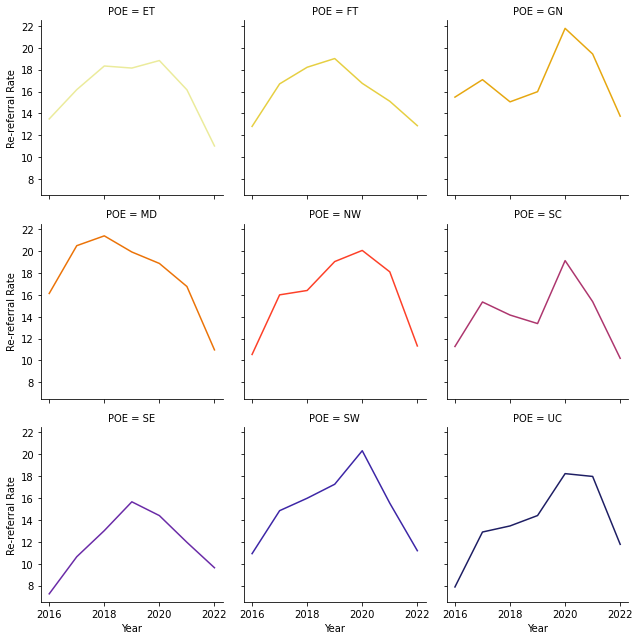

In [47]:
ti = sns.FacetGrid(poey_rerate, col="POE", col_wrap=3, hue="POE", palette = 'CMRmap_r')
ti.map_dataframe(sns.lineplot, x="Notification Year", y="Re-referral Rate")
ti.set_axis_labels("Year", "Re-referral Rate");

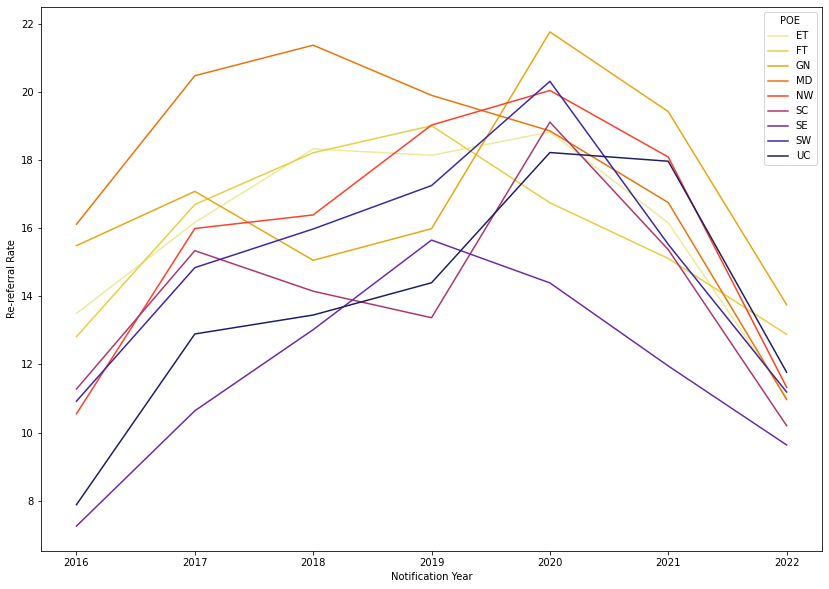

In [48]:
tij = sns.lineplot(x="Notification Year", y="Re-referral Rate", data=poey_rerate, hue="POE", palette = 'CMRmap_r')
tij.figure.set_size_inches(14, 10);

#### POE List
    - FT: First Tennessee
    - UC: Upper Cumberland
    - NW Northwest
    - ET: East Tennessee
    - GN: Greater Nashville
    - SW: Southwest
    - SE: Southeast
    - SC: South Central
    - MD: Memphis Delta

### Bullet 2
A referral is considered a "successful" referral if it results in an Individualized Family Service Plan (IFSP). 

    -Are there referral sources that have had higher rates of successful referrals? 

You can determine whether a referral was successful by looking at whether the Initial IFSP Date column is filled in or whether the Child Phase column is equal to IFSP.

In [49]:
ifsp = teis_merge2.loc[teis_merge2['Child Phase'] == 'IFSP']
ifsp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45519 entries, 4 to 114363
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype          
---  ------                     --------------  -----          
 0   Child ID                   45519 non-null  int64          
 1   DOB                        45519 non-null  datetime64[ns] 
 2   Notification Date          45519 non-null  datetime64[ns] 
 3   Referral Age               45519 non-null  timedelta64[ns]
 4   Referral Source Type Name  45519 non-null  object         
 5   Child Phase                45519 non-null  object         
 6   Exit Reason                36053 non-null  object         
 7   Exit Date                  36040 non-null  datetime64[ns] 
 8   Exit Age                   36040 non-null  timedelta64[ns]
 9   Service Coordinator        45519 non-null  object         
 10  Parent Consent             45475 non-null  datetime64[ns] 
 11  Initial Eligibility        45519 non-null  object    

In [50]:
refsou_suc = ifsp.groupby(['Referral Source Type Name'])['Child ID'].count()
refsou_suc = refsou_suc.to_frame().reset_index()
refsou_suc = refsou_suc.rename(columns = {'Child ID' : 'Total Successful Referrals'})
refsou_suc
#Child ID count for successful referrals by referral source (as defined by reaching IFSP phase)

,Referral Source Type Name,Total Successful Referrals
0,Child Care provider,175
1,Community/Child Find Activity,155
2,DCS,4502
3,DHS,3
4,DMRS,1
5,Dept. of Health,1381
6,EIRA,170
7,Early Head Start/Head Start,423
8,Family and Friends,280
9,Foster Parent,262


In [51]:
refsou_sucrate = pd.merge(refsou_ref, refsou_suc, how='left').fillna(0)
refsou_sucrate['Success Rate'] = (refsou_sucrate['Total Successful Referrals'] / refsou_sucrate['Total Referrals'])*100
refsou_sucrate

,Referral Source Type Name,Total Referrals,Total Successful Referrals,Success Rate
0,CAPTA,2,0.0,0.000000
1,Child Care provider,430,175.0,40.697674
2,Community/Child Find Activity,385,155.0,40.259740
3,DCS,25716,4502.0,17.506611
4,DHS,12,3.0,25.000000
5,DMRS,1,1.0,100.000000
6,Dept. of Health,3683,1381.0,37.496606
7,EIRA,352,170.0,48.295455
8,Early Head Start/Head Start,1026,423.0,41.228070
9,Family and Friends,524,280.0,53.435115


### Bullet 3
Some areas of potential concern are POEs having a:

        -low proportion of referrals, 
        -a high average age of referrals, 
        -a low percent of total referrals resulting in an IFSP or 
        -a lower percent of eligible referrals resulting in an IFSP. 
        
    -How do POEs compare on these metrics, and 
    -which POEs are of concern on the basis of one or more of the listed criteria?

In [52]:
teis_merge2.columns

Index(['Child ID', 'DOB', 'Notification Date', 'Referral Age',
       'Referral Source Type Name', 'Child Phase', 'Exit Reason', 'Exit Date',
       'Exit Age', 'Service Coordinator', 'Parent Consent',
       'Initial Eligibility', 'Initial Eligibility Date', 'Initial IFSP Date',
       'Latest IFSP', 'Late Referral', 'third_DOB', 'POE', 'County Name',
       'County SES', 'Tenn Region', 'Fiscal Year', 'Fiscal Year.1',
       'Notification Month', 'Qtr', 'Notification Year', 'Active'],
      dtype='object')

In [53]:
teis_merge2.loc[teis_merge2['Referral Age'] < '0 days']
#there is one child whose birthdate must be wrong because they have a negative age at time of referral

,Child ID,DOB,Notification Date,Referral Age,Referral Source Type Name,Child Phase,Exit Reason,Exit Date,Exit Age,Service Coordinator,...,POE,County Name,County SES,Tenn Region,Fiscal Year,Fiscal Year.1,Notification Month,Qtr,Notification Year,Active
730,393629,2018-12-31,2018-07-06,-178 days,Parent,IFSP,618 - Deceased,2021-12-18,1083 days,Esther Bouie,...,MD,Shelby,Transitional,NaN,NaN,NaN,NaN,NaN,2018,I


In [54]:
teis_merge2.loc[teis_merge2['Child ID'] == 393629]
#Confirming that child only appears once in the table, so can't correct the birthdate

,Child ID,DOB,Notification Date,Referral Age,Referral Source Type Name,Child Phase,Exit Reason,Exit Date,Exit Age,Service Coordinator,...,POE,County Name,County SES,Tenn Region,Fiscal Year,Fiscal Year.1,Notification Month,Qtr,Notification Year,Active
730,393629,2018-12-31,2018-07-06,-178 days,Parent,IFSP,618 - Deceased,2021-12-18,1083 days,Esther Bouie,...,MD,Shelby,Transitional,NaN,NaN,NaN,NaN,NaN,2018,I


In [55]:
teis_merge2 = teis_merge2.loc[teis_merge2['Referral Age'] >= '0 days']
#dropping the instance of a negative age so that it doesn't skew the average for that POE

In [56]:
teis_merge2['Referral Age'].describe()

count                         115523
mean     468 days 04:18:56.189330256
std      320 days 08:20:26.249299884
min                  0 days 00:00:00
25%                138 days 00:00:00
50%                503 days 00:00:00
75%                742 days 00:00:00
max               3896 days 00:00:00
Name: Referral Age, dtype: object

In [57]:
poe_ref_prop = poe_ref
poe_ref_prop['Proportion of Referrals'] = (poe_ref_prop['Total Referrals']/poe_ref_prop['Total Referrals'].sum())*100
poe_ref_prop
#finding what proportion of total referrals each POE handles

,POE,Total Referrals,Proportion of Referrals
0,ET,20583,17.817077
1,FT,11335,9.811814
2,GN,20239,17.519303
3,MD,17642,15.271286
4,NW,6592,5.706174
5,SC,14967,12.955749
6,SE,8790,7.608809
7,SW,6142,5.316644
8,UC,9234,7.993144


It appears that the Northwest and Southwest POEs have particularly low proportions of referrals. I would like to see if there's a way to pull population data in to see if that correlates, though.

In [58]:
poe_ref_age = teis_merge2.groupby(['POE'])['Referral Age'].mean()
poe_ref_age = poe_ref_age.to_frame().sort_values('Referral Age')
poe_ref_age = poe_ref_age.rename(columns = {'Referral Age' : 'Avg Referral Age in days'})
poe_ref_age['Avg Referral Age in months'] = (poe_ref_age['Avg Referral Age in days']).astype('timedelta64[M]')
poe_ref_age['Difference from Overall Avg in days'] = (poe_ref_age['Avg Referral Age in days']-(teis_merge2['Referral Age'].mean())).astype('timedelta64[D]')
poe_ref_age['Avg Referral Age in days'] = (poe_ref_age['Avg Referral Age in days']).astype('timedelta64[D]')
poe_ref_age

,Avg Referral Age in days,Avg Referral Age in months,Difference from Overall Avg in days
POE,,,
FT,426.0,14.0,-42.0
NW,429.0,14.0,-40.0
SE,436.0,14.0,-32.0
SW,438.0,14.0,-30.0
ET,451.0,14.0,-17.0
MD,469.0,15.0,0.0
UC,473.0,15.0,5.0
GN,502.0,16.0,34.0
SC,518.0,17.0,50.0


Greater Nashville and South Central may be of concern in this area because there are just over a month and just under two months, respectively, above the overall average age of referral

In [59]:
poe_suc = ifsp.groupby(['POE'])['Child ID'].count()
poe_suc = poe_suc.to_frame().reset_index()
poe_suc = poe_suc.rename(columns = {'Child ID' : 'Total Successful Referrals'})
poe_suc

,POE,Total Successful Referrals
0,ET,7628
1,FT,4727
2,GN,7499
3,MD,6078
4,NW,2101
5,SC,7011
6,SE,3426
7,SW,2516
8,UC,4533


In [60]:
poe_sucrate = pd.merge(poe_ref, poe_suc, how='left').fillna(0)
poe_sucrate['Referral Success Rate'] = (poe_sucrate['Total Successful Referrals'] / poe_ref['Total Referrals'])*100
poe_sucrate

,POE,Total Referrals,Proportion of Referrals,Total Successful Referrals,Referral Success Rate
0,ET,20583,17.817077,7628,37.059709
1,FT,11335,9.811814,4727,41.702691
2,GN,20239,17.519303,7499,37.052226
3,MD,17642,15.271286,6078,34.451876
4,NW,6592,5.706174,2101,31.871966
5,SC,14967,12.955749,7011,46.843055
6,SE,8790,7.608809,3426,38.976109
7,SW,6142,5.316644,2516,40.963855
8,UC,9234,7.993144,4533,49.090318


### Bullet 4
Look for patterns in referrals and re-referrals on the basis of the following:

    - Age
    - Referral source
    - Socioeconomic status (County SES)

### Bullet 5
TEIS provides services to eligible infants and toddlers from birth to age 3. 

    -Are there any POE or service coordinators with high rates of early closure (a child exiting before reaching age 3)? 
    -For this question, only consider cases which have reached the IFSP phase.

In [61]:
ifsp_exit = ifsp.dropna(subset=['Exit Date'])
ifsp_exit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36040 entries, 4 to 113003
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype          
---  ------                     --------------  -----          
 0   Child ID                   36040 non-null  int64          
 1   DOB                        36040 non-null  datetime64[ns] 
 2   Notification Date          36040 non-null  datetime64[ns] 
 3   Referral Age               36040 non-null  timedelta64[ns]
 4   Referral Source Type Name  36040 non-null  object         
 5   Child Phase                36040 non-null  object         
 6   Exit Reason                36040 non-null  object         
 7   Exit Date                  36040 non-null  datetime64[ns] 
 8   Exit Age                   36040 non-null  timedelta64[ns]
 9   Service Coordinator        36040 non-null  object         
 10  Parent Consent             36007 non-null  datetime64[ns] 
 11  Initial Eligibility        36040 non-null  object    

In [62]:
ifsp_exit = ifsp_exit.loc[ifsp_exit['Referral Age'] > '0 days']
ifsp_exit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36039 entries, 4 to 113003
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype          
---  ------                     --------------  -----          
 0   Child ID                   36039 non-null  int64          
 1   DOB                        36039 non-null  datetime64[ns] 
 2   Notification Date          36039 non-null  datetime64[ns] 
 3   Referral Age               36039 non-null  timedelta64[ns]
 4   Referral Source Type Name  36039 non-null  object         
 5   Child Phase                36039 non-null  object         
 6   Exit Reason                36039 non-null  object         
 7   Exit Date                  36039 non-null  datetime64[ns] 
 8   Exit Age                   36039 non-null  timedelta64[ns]
 9   Service Coordinator        36039 non-null  object         
 10  Parent Consent             36006 non-null  datetime64[ns] 
 11  Initial Eligibility        36039 non-null  object    

In [63]:
all_early_exits = ifsp_exit.loc[ifsp_exit['Exit Age'] < '1092 days']
all_early_exits

,Child ID,DOB,Notification Date,Referral Age,Referral Source Type Name,Child Phase,Exit Reason,Exit Date,Exit Age,Service Coordinator,...,POE,County Name,County SES,Tenn Region,Fiscal Year,Fiscal Year.1,Notification Month,Qtr,Notification Year,Active
8,354276,2013-12-24,2016-08-04,954 days,DCS,IFSP,618 - Parent withdraw,2016-09-22,1003 days,Kristi Borer,...,ET,Blount,Transitional,Eastern,2016-2017,2016.0,Aug,1.0,2016,I
52,364743,2014-03-13,2016-07-06,846 days,Parent,IFSP,618 - Parent withdraw,2016-07-08,848 days,Jennifer Johnson,...,GN,Davidson,Competitive,Middle,2016-2017,2016.0,Jul,1.0,2016,I
57,365848,2014-04-03,2016-09-08,889 days,Hospital,IFSP,618 - Attempts to contact unsuccessful,2016-10-12,923 days,Cathy Taylor,...,ET,Morgan,At-Risk,Eastern,2016-2017,2016.0,Sep,1.0,2016,I
67,368391,2014-06-15,2016-08-23,800 days,DCS,IFSP,618 - Attempts to contact unsuccessful,2017-05-23,1073 days,Elizabeth Hailey,...,SW,Madison,Transitional,Western,2016-2017,2016.0,Aug,1.0,2016,I
107,379122,2014-05-02,2017-02-13,1018 days,PCP,IFSP,618 - Parent withdraw,2017-04-19,1083 days,Anna Bolin,...,UC,White,Transitional,Middle,2016-2017,2016.0,Feb,3.0,2017,I
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112126,527606,2021-12-09,2022-04-27,139 days,PCP,IFSP,618 - Moved out of state,2022-06-27,200 days,Kelly Holt,...,SC,Rutherford,Competitive,Middle,2021-2022,2021.0,Apr,4.0,2022,I
112129,527609,2019-08-26,2022-04-27,975 days,Parent,IFSP,618 - Parent withdraw,2022-06-13,1022 days,Torkwase Smith,...,MD,Shelby,Transitional,Western,2021-2022,2021.0,Apr,4.0,2022,I
112174,527688,2020-04-24,2022-04-28,734 days,PCP,IFSP,618 - Parent withdraw,2022-06-08,775 days,Brittney Blalock Rose,...,SC,Williamson,Attainment,Middle,2021-2022,2021.0,Apr,4.0,2022,I
112689,528318,2021-09-26,2022-05-09,225 days,PCP,IFSP,618 - Attempts to contact unsuccessful,2022-07-01,278 days,Marian Kingery,...,MD,Shelby,Transitional,Western,2021-2022,2021.0,May,4.0,2022,I


In [64]:
early_exits = all_early_exits.loc[~all_early_exits['Exit Reason'].isin(['618 - Completion of IFSP/ no longer requires services',
                                                                      '618 - Moved out of state', '618 - Deceased'])]
early_exits

,Child ID,DOB,Notification Date,Referral Age,Referral Source Type Name,Child Phase,Exit Reason,Exit Date,Exit Age,Service Coordinator,...,POE,County Name,County SES,Tenn Region,Fiscal Year,Fiscal Year.1,Notification Month,Qtr,Notification Year,Active
8,354276,2013-12-24,2016-08-04,954 days,DCS,IFSP,618 - Parent withdraw,2016-09-22,1003 days,Kristi Borer,...,ET,Blount,Transitional,Eastern,2016-2017,2016.0,Aug,1.0,2016,I
52,364743,2014-03-13,2016-07-06,846 days,Parent,IFSP,618 - Parent withdraw,2016-07-08,848 days,Jennifer Johnson,...,GN,Davidson,Competitive,Middle,2016-2017,2016.0,Jul,1.0,2016,I
57,365848,2014-04-03,2016-09-08,889 days,Hospital,IFSP,618 - Attempts to contact unsuccessful,2016-10-12,923 days,Cathy Taylor,...,ET,Morgan,At-Risk,Eastern,2016-2017,2016.0,Sep,1.0,2016,I
67,368391,2014-06-15,2016-08-23,800 days,DCS,IFSP,618 - Attempts to contact unsuccessful,2017-05-23,1073 days,Elizabeth Hailey,...,SW,Madison,Transitional,Western,2016-2017,2016.0,Aug,1.0,2016,I
107,379122,2014-05-02,2017-02-13,1018 days,PCP,IFSP,618 - Parent withdraw,2017-04-19,1083 days,Anna Bolin,...,UC,White,Transitional,Middle,2016-2017,2016.0,Feb,3.0,2017,I
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111980,527434,2020-01-10,2022-04-25,836 days,PCP,IFSP,618 - Parent withdraw,2022-06-09,881 days,Diane Brewington,...,UC,Macon,Transitional,Middle,2021-2022,2021.0,Apr,4.0,2022,I
112129,527609,2019-08-26,2022-04-27,975 days,Parent,IFSP,618 - Parent withdraw,2022-06-13,1022 days,Torkwase Smith,...,MD,Shelby,Transitional,Western,2021-2022,2021.0,Apr,4.0,2022,I
112174,527688,2020-04-24,2022-04-28,734 days,PCP,IFSP,618 - Parent withdraw,2022-06-08,775 days,Brittney Blalock Rose,...,SC,Williamson,Attainment,Middle,2021-2022,2021.0,Apr,4.0,2022,I
112689,528318,2021-09-26,2022-05-09,225 days,PCP,IFSP,618 - Attempts to contact unsuccessful,2022-07-01,278 days,Marian Kingery,...,MD,Shelby,Transitional,Western,2021-2022,2021.0,May,4.0,2022,I


In [65]:
POE_exits = ifsp_exit.groupby('POE')['Child ID'].count()
POE_exits = POE_exits.to_frame().reset_index()
POE_exits = POE_exits.rename(columns = {'Child ID' : 'Total Exits'})
POE_exits

,POE,Total Exits
0,ET,5920
1,FT,3749
2,GN,5890
3,MD,4847
4,NW,1701
5,SC,5544
6,SE,2722
7,SW,2050
8,UC,3616


In [66]:
POE_early_exits = early_exits.groupby('POE')['Child ID'].count()
POE_early_exits = POE_early_exits.to_frame().reset_index()
POE_early_exits = POE_early_exits.rename(columns = {'Child ID' : 'Total Early Exits'})
POE_early_exits

,POE,Total Early Exits
0,ET,2389
1,FT,1434
2,GN,1849
3,MD,1785
4,NW,763
5,SC,1871
6,SE,989
7,SW,1062
8,UC,1426


In [67]:
POE_early_exit_rate = pd.merge(POE_exits, POE_early_exits)
POE_early_exit_rate['Early Exit Rate'] = round((POE_early_exit_rate['Total Early Exits']/
                                                POE_early_exit_rate['Total Exits'])*100, 2)
POE_early_exit_rate = POE_early_exit_rate.sort_values('Early Exit Rate')
POE_early_exit_rate

,POE,Total Exits,Total Early Exits,Early Exit Rate
2,GN,5890,1849,31.39
5,SC,5544,1871,33.75
6,SE,2722,989,36.33
3,MD,4847,1785,36.83
1,FT,3749,1434,38.25
8,UC,3616,1426,39.44
0,ET,5920,2389,40.35
4,NW,1701,763,44.86
7,SW,2050,1062,51.80


In [68]:
POE_early_exit_rate['Total Early Exits'].sum()/POE_early_exit_rate['Total Exits'].sum()

0.3764810344349177

In [69]:
tee = POE_early_exits.groupby('POE')['Total Early Exits'].sum().sort_values(ascending=False)
tee

POE
ET    2389
SC    1871
GN    1849
MD    1785
FT    1434
UC    1426
SW    1062
SE     989
NW     763
Name: Total Early Exits, dtype: int64

In [70]:
full_palette = ["#D9ED92", "#B5E48C", "#99D98C", "#76C893", "#52B69A", "#34A0A4", "#168AAD", "#1A759F", "#1E6091", "#184E77"]

main_palette = ["#76C893", "#1E6091"]

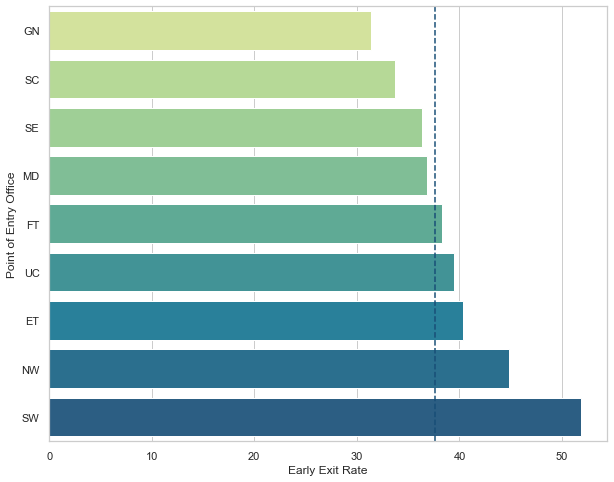

In [141]:
sns.set_theme(style="whitegrid")
eepoe = sns.barplot(x="Early Exit Rate", y="POE", data = POE_early_exit_rate, palette=full_palette)
plt.xlabel("Early Exit Rate")
plt.ylabel("Point of Entry Office")
eepoe.figure.set_size_inches(10, 8)
eepoe.axvline(37.65, linestyle = '--', color='#184E77');
plt.savefig('../data/eepoe.png', transparent=True)

very_early_exits = ifsp_exit.loc[ifsp_exit['Exit Age'] < '1005 days']
very_early_exits

very_early_exits = very_early_exits.loc[~very_early_exits['Exit Reason'].isin(['618 - Completion of IFSP/ no longer requires services',
                                                                      '618 - Moved out of state', '618 - Deceased'])]
very_early_exits

POE_vearly_exits = very_early_exits.groupby('POE')['Child ID'].count()
POE_vearly_exits = POE_vearly_exits.to_frame().reset_index()
POE_vearly_exits = POE_vearly_exits.rename(columns = {'Child ID' : 'Total Very Early Exits'})
POE_vearly_exits

POE_vearly_exit_rate = pd.merge(POE_exits, POE_vearly_exits)
POE_vearly_exit_rate['Very Early Exit Rate'] = round((POE_vearly_exit_rate['Total Very Early Exits']/POE_vearly_exit_rate['Total Exits'])*100, 2)
POE_vearly_exit_rate

In [72]:
POE_svc_early_exits = early_exits.groupby(['POE', 'Service Coordinator'])['Child ID'].count()
POE_svc_early_exits = POE_svc_early_exits.to_frame().reset_index()
POE_svc_early_exits = POE_svc_early_exits.rename(columns = {'Child ID' : 'Total Early Exits'})
POE_svc_early_exits

,POE,Service Coordinator,Total Early Exits
0,ET,Aaron Collins,68
1,ET,Adrianne McPeake,37
2,ET,Amanda Blair,19
3,ET,Amanda Cooke,53
4,ET,Amanda Cooke - PC,3
...,...,...,...
310,UC,Nicole Smith,80
311,UC,Sherry Roberts-DS,2
312,UC,Steven Scarlett,132
313,UC,Taylor Lee,80


In [73]:
POE_svc_exits = ifsp_exit.groupby(['POE', 'Service Coordinator'])['Child ID'].count()
POE_svc_exits = POE_svc_exits.to_frame().reset_index()
POE_svc_exits = POE_svc_exits.rename(columns = {'Child ID' : 'Total Exits'})
POE_svc_exits = POE_svc_exits.loc[POE_svc_exits['Total Exits'] > 3]
POE_svc_exits

,POE,Service Coordinator,Total Exits
0,ET,Aaron Collins,153
1,ET,Adrianne McPeake,71
2,ET,Amanda Blair,30
3,ET,Amanda Cooke,112
4,ET,Amanda Cooke - PC,5
...,...,...,...
329,UC,Miriam Espinosa,272
330,UC,Nicole Smith,255
332,UC,Steven Scarlett,277
333,UC,Taylor Lee,271


In [74]:
POE_svc_exits['Service Coordinator'].value_counts()

Brittany Smith        2
Taylor Watson         2
Cecile Buchanan       2
Anna Bolin            2
Andrea Smith          1
                     ..
Lizzie Ristucci       1
Londa Walker          1
Marcia Jordan         1
Marguarite Stewart    1
Taylor Lee            1
Name: Service Coordinator, Length: 289, dtype: int64

In [75]:
POE_svc_early_exit_rate = pd.merge(POE_svc_exits, POE_svc_early_exits,  how='left')
POE_svc_early_exit_rate['Early Exit Rate'] = round((POE_svc_early_exit_rate['Total Early Exits']/
                                                POE_svc_early_exit_rate['Total Exits'])*100, 2)
POE_svc_early_exit_rate = POE_svc_early_exit_rate.fillna(0)
POE_svc_early_exit_rate.sort_values('Early Exit Rate', ascending=False)

,POE,Service Coordinator,Total Exits,Total Early Exits,Early Exit Rate
122,GN,Taylor Watson,4,4.0,100.00
153,MD,JoAnn Hinkle-DA,11,11.0,100.00
26,ET,Kaitlin Lippert,9,8.0,88.89
161,MD,Lamar Meaders,8,7.0,87.50
166,MD,Marian Kingery,55,48.0,87.27
...,...,...,...,...,...
66,FT,Kimberly KetronPC,23,1.0,4.35
27,ET,Karen Stock,4,0.0,0.00
42,ET,Signal Centers-EEA,5,0.0,0.00
244,SE,Holly Wilson,6,0.0,0.00


In [77]:
UC_early_exits = POE_svc_early_exit_rate.loc[POE_svc_early_exit_rate['POE'] == 'UC'].nlargest(5, 'Early Exit Rate')
FT_early_exits = POE_svc_early_exit_rate.loc[POE_svc_early_exit_rate['POE'] == 'FT'].nlargest(5, 'Early Exit Rate')
NW_early_exits = POE_svc_early_exit_rate.loc[POE_svc_early_exit_rate['POE'] == 'NW'].nlargest(5, 'Early Exit Rate')
ET_early_exits = POE_svc_early_exit_rate.loc[POE_svc_early_exit_rate['POE'] == 'ET'].nlargest(5, 'Early Exit Rate')
GN_early_exits = POE_svc_early_exit_rate.loc[POE_svc_early_exit_rate['POE'] == 'GN'].nlargest(5, 'Early Exit Rate')
SW_early_exits = POE_svc_early_exit_rate.loc[POE_svc_early_exit_rate['POE'] == 'SW'].nlargest(5, 'Early Exit Rate')
SE_early_exits = POE_svc_early_exit_rate.loc[POE_svc_early_exit_rate['POE'] == 'SE'].nlargest(5, 'Early Exit Rate')
SC_early_exits = POE_svc_early_exit_rate.loc[POE_svc_early_exit_rate['POE'] == 'SC'].nlargest(5, 'Early Exit Rate')
MD_early_exits = POE_svc_early_exit_rate.loc[POE_svc_early_exit_rate['POE'] == 'MD'].nlargest(5, 'Early Exit Rate')
POE_svc_high_ee = pd.concat([UC_early_exits, FT_early_exits, NW_early_exits, ET_early_exits, GN_early_exits,
                              SW_early_exits, SE_early_exits, SC_early_exits, MD_early_exits])
POE_svc_high_ee

,POE,Service Coordinator,Total Exits,Total Early Exits,Early Exit Rate
292,UC,Taylor Watson,73,43.0,58.90
284,UC,Heather Craig,244,134.0,54.92
277,UC,A.J. Cowan,59,29.0,49.15
278,UC,Anna Bolin,251,121.0,48.21
290,UC,Steven Scarlett,277,132.0,47.65
75,FT,Regina Bowman,11,8.0,72.73
67,FT,Kristi Morelock,78,52.0,66.67
74,FT,Rebecca Taylor,86,54.0,62.79
77,FT,Susan St. Lawrence,10,6.0,60.00
53,FT,Amanda Royston,61,35.0,57.38


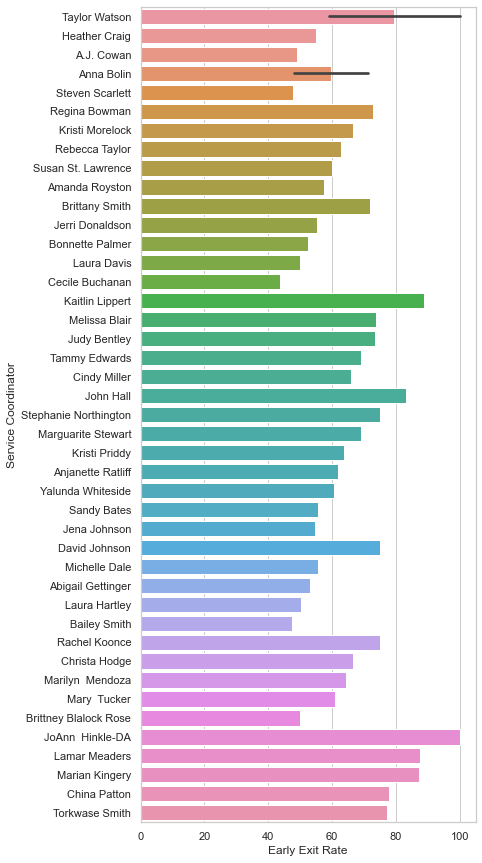

In [78]:
sns.set_theme(style="whitegrid")
hee = sns.barplot(x="Early Exit Rate", y="Service Coordinator", data = POE_svc_high_ee)
hee.figure.set_size_inches(6, 15)

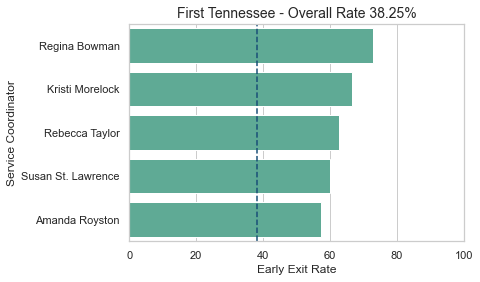

In [144]:
sns.set_theme(style="whitegrid")
heeft = sns.barplot(x="Early Exit Rate", y="Service Coordinator", data = FT_early_exits, color='#52B69A')
heeft.axvline(38.25, linestyle = '--', color='#184E77')
plt.title('First Tennessee - Overall Rate 38.25%', fontsize=14)
plt.xlabel("Early Exit Rate")
plt.ylabel("Service Coordinator")
heeft.set(xlim=(0, 100))
heeft.figure.set_size_inches(6, 4);
plt.savefig('../data/heeft.png', bbox_inches = 'tight', transparent=True)

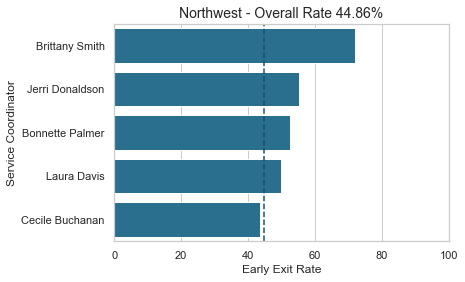

In [145]:
sns.set_theme(style="whitegrid")
heenw = sns.barplot(x="Early Exit Rate", y="Service Coordinator", data = NW_early_exits, color='#1A759F')
heenw.axvline(44.86, linestyle = '--', color='#184E77')
plt.title('Northwest - Overall Rate 44.86%', fontsize=14)
plt.xlabel("Early Exit Rate")
plt.ylabel("Service Coordinator")
heenw.set(xlim=(0, 100))
heenw.figure.set_size_inches(6, 4);
plt.savefig('../data/heenw.png', bbox_inches = 'tight', transparent=True)

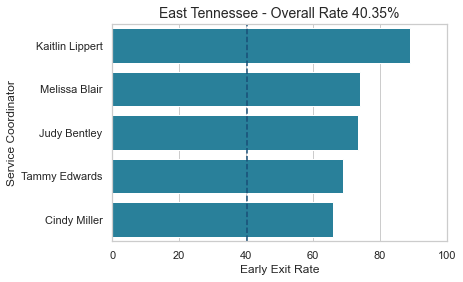

In [146]:
sns.set_theme(style="whitegrid")
heeet = sns.barplot(x="Early Exit Rate", y="Service Coordinator", data = ET_early_exits, color='#168AAD')
heeet.axvline(40.35, linestyle = '--', color='#184E77')
plt.title('East Tennessee - Overall Rate 40.35%', fontsize=14)
plt.xlabel("Early Exit Rate")
plt.ylabel("Service Coordinator")
heeet.set(xlim=(0, 100))
heeet.figure.set_size_inches(6, 4);
plt.savefig('../data/heeet.png', bbox_inches = 'tight', transparent=True)

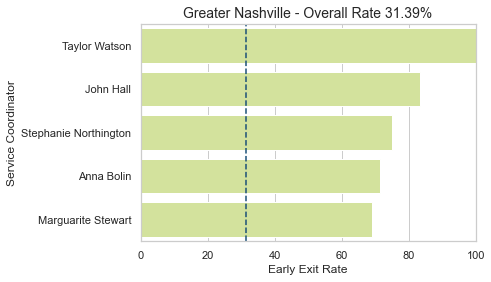

In [147]:
sns.set_theme(style="whitegrid")
heegn = sns.barplot(x="Early Exit Rate", y="Service Coordinator", data = GN_early_exits, color='#D9ED92')
heegn.axvline(31.39, linestyle = '--', color='#184E77')
plt.title('Greater Nashville - Overall Rate 31.39%', fontsize=14)
plt.xlabel("Early Exit Rate")
plt.ylabel("Service Coordinator")
heegn.set(xlim=(0, 100))
heegn.figure.set_size_inches(6, 4);
plt.savefig('../data/heegn.png', bbox_inches = 'tight', transparent=True)

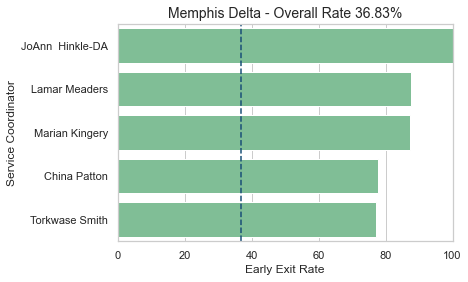

In [148]:
sns.set_theme(style="whitegrid")
heemd = sns.barplot(x="Early Exit Rate", y="Service Coordinator", data = MD_early_exits, color='#76C893')
heemd.axvline(36.83, linestyle = '--', color='#184E77')
plt.title('Memphis Delta - Overall Rate 36.83%', fontsize=14)
plt.xlabel("Early Exit Rate")
plt.ylabel("Service Coordinator")
heemd.set(xlim=(0, 100))
heemd.figure.set_size_inches(6, 4);
plt.savefig('../data/heemd.png', bbox_inches = 'tight', transparent=True)

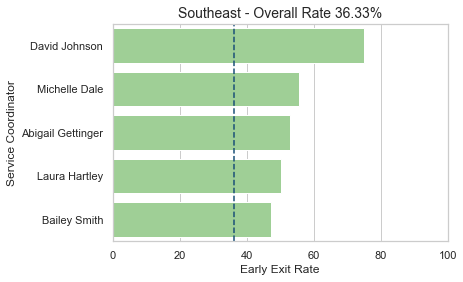

In [149]:
sns.set_theme(style="whitegrid")
heese = sns.barplot(x="Early Exit Rate", y="Service Coordinator", data = SE_early_exits, color='#99D98C')
heese.axvline(36.33, linestyle = '--', color='#184E77')
plt.title('Southeast - Overall Rate 36.33%', fontsize=14)
plt.xlabel("Early Exit Rate")
plt.ylabel("Service Coordinator")
heese.set(xlim=(0, 100))
heese.figure.set_size_inches(6, 4);
plt.savefig('../data/heese.png', bbox_inches = 'tight', transparent=True)

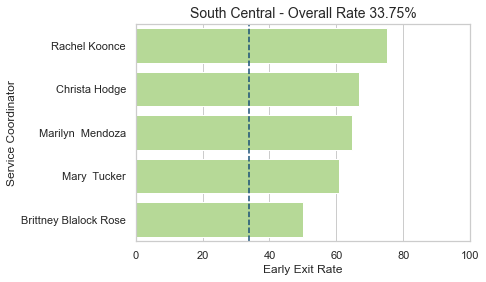

In [150]:
sns.set_theme(style="whitegrid")
heesc = sns.barplot(x="Early Exit Rate", y="Service Coordinator", data = SC_early_exits, color='#B5E48C')
heesc.axvline(33.75, linestyle = '--', color='#184E77')
plt.title('South Central - Overall Rate 33.75%', fontsize=14)
plt.xlabel("Early Exit Rate")
plt.ylabel("Service Coordinator")
heesc.set(xlim=(0, 100))
heesc.figure.set_size_inches(6, 4);
plt.savefig('../data/heesc.png', bbox_inches = 'tight', transparent=True)

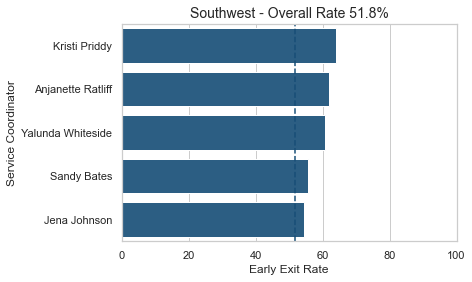

In [151]:
sns.set_theme(style="whitegrid")
heesw = sns.barplot(x="Early Exit Rate", y="Service Coordinator", data = SW_early_exits, color='#1E6091')
heesw.axvline(51.8, linestyle = '--', color='#184E77')
plt.title('Southwest - Overall Rate 51.8%', fontsize=14)
plt.xlabel("Early Exit Rate")
plt.ylabel("Service Coordinator")
heesw.set(xlim=(0, 100))
heesw.figure.set_size_inches(6, 4);
plt.savefig('../data/heesw.png', bbox_inches = 'tight', transparent=True)

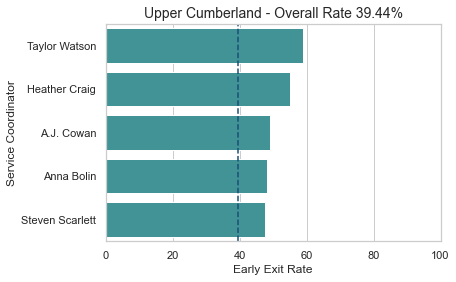

In [152]:
sns.set_theme(style="whitegrid")
heeuc = sns.barplot(x="Early Exit Rate", y="Service Coordinator", data = UC_early_exits, color='#34A0A4')
heeuc.axvline(39.44, linestyle = '--', color='#184E77')
plt.title('Upper Cumberland - Overall Rate 39.44%', fontsize=14)
plt.xlabel("Early Exit Rate")
plt.ylabel("Service Coordinator")
heeuc.set(xlim=(0, 100))
heeuc.figure.set_size_inches(6, 4);
plt.savefig('../data/heeuc.png', bbox_inches = 'tight', transparent=True)

In [95]:
UC_aa_early_exits = POE_svc_early_exit_rate.loc[((POE_svc_early_exit_rate['POE'] == 'UC') & (POE_svc_early_exit_rate['Early Exit Rate'] > 39.44))]
FT_aa_early_exits = POE_svc_early_exit_rate.loc[((POE_svc_early_exit_rate['POE'] == 'FT') & (POE_svc_early_exit_rate['Early Exit Rate'] > 38.25))]
NW_aa_early_exits = POE_svc_early_exit_rate.loc[((POE_svc_early_exit_rate['POE'] == 'NW') & (POE_svc_early_exit_rate['Early Exit Rate'] > 44.86))]
ET_aa_early_exits = POE_svc_early_exit_rate.loc[((POE_svc_early_exit_rate['POE'] == 'ET') & (POE_svc_early_exit_rate['Early Exit Rate'] > 40.35))]
GN_aa_early_exits = POE_svc_early_exit_rate.loc[((POE_svc_early_exit_rate['POE'] == 'GN') & (POE_svc_early_exit_rate['Early Exit Rate'] > 31.39))]
SW_aa_early_exits = POE_svc_early_exit_rate.loc[((POE_svc_early_exit_rate['POE'] == 'SW') & (POE_svc_early_exit_rate['Early Exit Rate'] > 51.8))]
SE_aa_early_exits = POE_svc_early_exit_rate.loc[((POE_svc_early_exit_rate['POE'] == 'SE') & (POE_svc_early_exit_rate['Early Exit Rate'] > 36.33))]
SC_aa_early_exits = POE_svc_early_exit_rate.loc[((POE_svc_early_exit_rate['POE'] == 'SC') & (POE_svc_early_exit_rate['Early Exit Rate'] > 33.75))]
MD_aa_early_exits = POE_svc_early_exit_rate.loc[((POE_svc_early_exit_rate['POE'] == 'MD') & (POE_svc_early_exit_rate['Early Exit Rate'] > 36.83))]
POE_svc_abavg = pd.concat([UC_aa_early_exits, FT_aa_early_exits, NW_aa_early_exits, ET_aa_early_exits, 
                           GN_aa_early_exits, SW_aa_early_exits, SE_aa_early_exits, SC_aa_early_exits, MD_aa_early_exits])
POE_svc_abavg

,POE,Service Coordinator,Total Exits,Total Early Exits,Early Exit Rate
277,UC,A.J. Cowan,59,29.0,49.15
278,UC,Anna Bolin,251,121.0,48.21
279,UC,Candace Peacock,271,126.0,46.49
281,UC,David Mutchmore,160,72.0,45.00
284,UC,Heather Craig,244,134.0,54.92
...,...,...,...,...,...
176,MD,Shewronda Stringer,27,15.0,55.56
177,MD,Stacey Brewer,25,17.0,68.00
178,MD,Stephanie Boyce,57,21.0,36.84
180,MD,Torkwase Smith,22,17.0,77.27


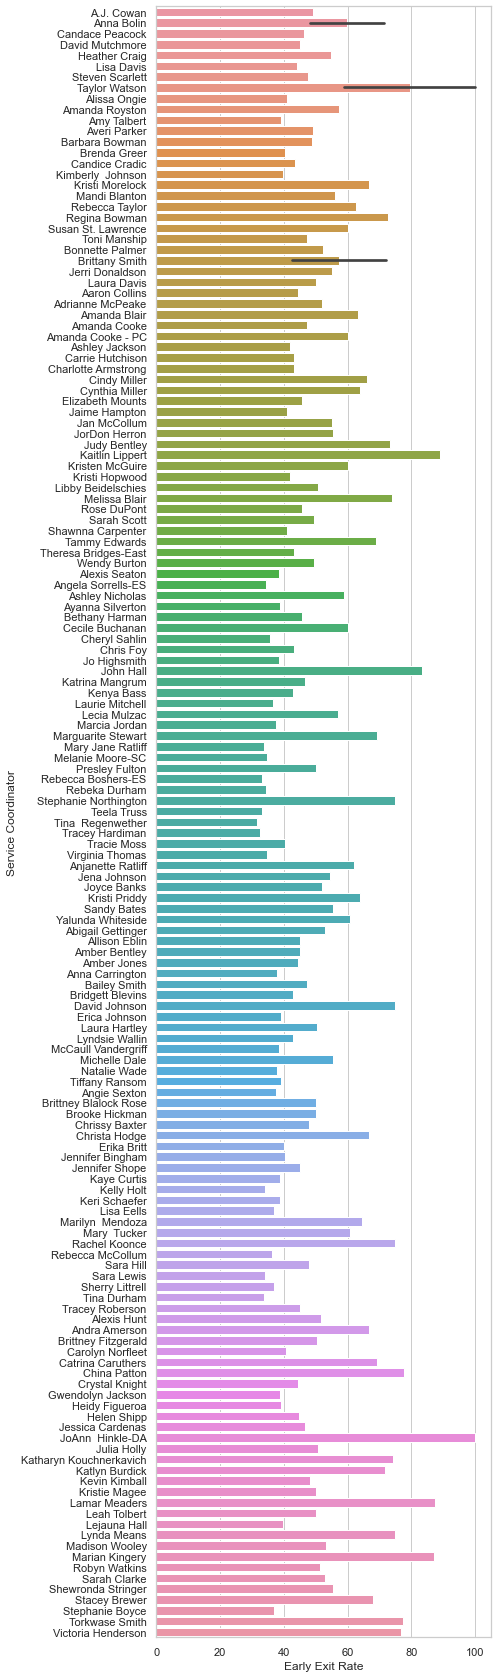

In [96]:
sns.set_theme(style="whitegrid")
aaee = sns.barplot(x="Early Exit Rate", y="Service Coordinator", data = POE_svc_abavg)
aaee.figure.set_size_inches(6, 30)

In [104]:
POE_abavg_count = POE_svc_abavg.groupby('POE')['Service Coordinator'].count()
POE_abavg_count = POE_abavg_count.to_frame().reset_index()
POE_abavg_count = POE_abavg_count.rename(columns={'Service Coordinator':'Total Service Coordinators w/ high EER'})
POE_abavg_count

,POE,Total Service Coordinators w/ high EER
0,ET,26
1,FT,14
2,GN,29
3,MD,31
4,NW,4
5,SC,21
6,SE,15
7,SW,6
8,UC,8


In [100]:
POE_svc_abavg.groupby('POE').describe()

Total Exits                                                              \
          count        mean         std   min     25%    50%     75%    max   
POE                                                                           
ET         26.0   93.423077   80.838195   5.0   26.25   73.5  135.25  270.0   
FT         14.0  110.928571   98.443630  10.0   32.00   69.5  197.75  296.0   
GN         29.0  104.137931  118.678655   4.0   14.00   56.0  131.00  415.0   
MD         31.0   60.161290   65.024660   4.0   20.00   39.0   59.00  295.0   
NW          4.0  155.500000   95.129736  25.0  118.75  176.5  213.25  244.0   
SC         21.0  127.523810   99.888247   5.0   31.00   94.0  215.00  294.0   
SE         15.0   94.533333   90.732627   7.0   27.50   79.0  137.50  347.0   
SW          6.0  183.500000  135.460326  11.0   70.50  231.0  264.75  335.0   
UC          8.0  198.625000   89.456993  59.0  138.25  247.5  258.25  277.0   

    Total Early Exits              ...                Early Exit Rate  \
                count        mean  ...     75%    max           count   
POE                                ...                                  
ET               26.0   45.769231  ...   65.75  134.0            26.0   
FT               14.0   51.285714  ...   79.25  145.0            14.0   
GN               29.0   38.793103  ...   56.00  148.0            29.0   
MD               31.0   30.064516  ...   31.00  117.0            31.0   
NW                4.0   83.250000  ...  116.00  128.0             4.0   
SC               21.0   52.523810  ...   88.00  118.0            21.0   
SE               15.0   40.600000  ...   61.50  131.0            15.0   
SW                6.0  107.833333  ...  157.50  214.0             6.0   
UC                8.0   96.125000  ...  127.50  134.0             8.0   

                                                                    
          mean        std    min      25%     50%      75%     max  
POE                                                                 
ET   54.213846  12.535507  40.91  43.5250  50.125  62.4975   88.89  
FT   51.760000  10.928405  39.22  41.6500  49.040  59.3450   72.73  
GN   47.318966  17.566666  31.70  34.8800  38.680  57.1400  100.00  
MD   58.706452  16.968536  36.84  45.5950  51.720  73.0750  100.00  
NW   57.407500   9.954836  50.00  51.8450  53.815  59.3775   72.00  
SC   45.751905  11.847123  33.85  36.9800  40.370  50.0000   75.00  
SE   46.279333   9.660224  37.75  39.2650  44.590  48.9050   75.00  
SW   58.100000   4.691665  52.05  54.8025  58.110  61.5900   63.88  
UC   49.301250   5.087908  44.09  46.1175  47.930  50.5925   58.90  

[9 rows x 24 columns]

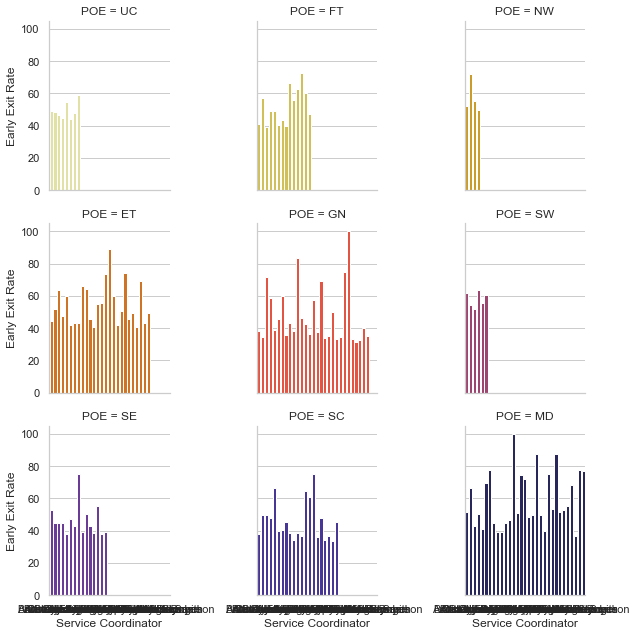

In [101]:
aaeesvc = sns.FacetGrid(POE_svc_abavg, col="POE", col_wrap=3, hue="POE", palette = 'CMRmap_r')
aaeesvc.map_dataframe(sns.barplot, x="Service Coordinator", y="Early Exit Rate")
aaeesvc.set_axis_labels("Service Coordinator", "Early Exit Rate");

In [102]:
POE_svc_exits.groupby('POE').describe()

Total Exits                                                            
          count        mean         std   min     25%    50%     75%    max
POE                                                                        
ET         49.0  120.693878   95.204211   4.0   30.00  110.0  200.00  282.0
FT         30.0  124.566667   93.928690   4.0   27.00  120.5  212.00  296.0
GN         50.0  117.320000  108.804532   4.0   18.00  103.0  161.25  415.0
MD         53.0   91.339623   95.975947   4.0   24.00   56.0  118.00  353.0
NW         12.0  141.750000  105.261687   7.0   24.75  176.5  233.50  260.0
SC         40.0  138.525000  102.024127   5.0   38.50  117.5  246.25  302.0
SE         24.0  113.041667  105.786692   6.0   19.75   88.0  186.00  347.0
SW         19.0  107.736842  113.670011   4.0   15.50   53.0  231.00  335.0
UC         16.0  225.562500   73.824087  59.0  214.25  252.5  271.00  323.0

In [103]:
POE_svc_count = POE_svc_exits.groupby('POE')['Service Coordinator'].count()
POE_svc_count = POE_svc_count.to_frame().reset_index()
POE_svc_count = POE_svc_count.rename(columns={'Service Coordinator':'Total Service Coordinators'})
POE_svc_count

,POE,Total Service Coordinators
0,ET,49
1,FT,30
2,GN,50
3,MD,53
4,NW,12
5,SC,40
6,SE,24
7,SW,19
8,UC,16


In [107]:
POE_aasvc_rate = pd.merge(POE_svc_count, POE_abavg_count)
POE_aasvc_rate['Percent of Service Coordinators with high EE rate'] = round((POE_aasvc_rate['Total Service Coordinators w/ high EER']/
                                                POE_aasvc_rate['Total Service Coordinators'])*100, 2)
POE_aasvc_rate = POE_aasvc_rate.sort_values('Percent of Service Coordinators with high EE rate')
POE_aasvc_rate

,POE,Total Service Coordinators,Total Service Coordinators w/ high EER,Percent of Service Coordinators with high EE rate
7,SW,19,6,31.58
4,NW,12,4,33.33
1,FT,30,14,46.67
8,UC,16,8,50.00
5,SC,40,21,52.50
0,ET,49,26,53.06
2,GN,50,29,58.00
3,MD,53,31,58.49
6,SE,24,15,62.50


In [140]:
POE_aasvc_rate['Total Service Coordinators w/ high EER'].sum() / POE_aasvc_rate['Total Service Coordinators'].sum()

0.5255972696245734

In [ ]:
sns.set_theme(style="whitegrid")
sns.factorplot(x='class', y='survival rate', hue='sex', data=df, kind='bar')
plt.title('Service Coordinators with Above Average Rate', fontsize=14)
plt.xlabel("Early Exit Rate")
plt.ylabel("Service Coordinator")
heeuc.figure.set_size_inches(6, 4);

In [130]:
POE_svc_early_exit_rate.loc[POE_svc_early_exit_rate['Early Exit Rate'] > 37.65]

,POE,Service Coordinator,Total Exits,Total Early Exits,Early Exit Rate
0,ET,Aaron Collins,153,68.0,44.44
1,ET,Adrianne McPeake,71,37.0,52.11
2,ET,Amanda Blair,30,19.0,63.33
3,ET,Amanda Cooke,112,53.0,47.32
4,ET,Amanda Cooke - PC,5,3.0,60.00
...,...,...,...,...,...
281,UC,David Mutchmore,160,72.0,45.00
284,UC,Heather Craig,244,134.0,54.92
287,UC,Lisa Davis,254,112.0,44.09
290,UC,Steven Scarlett,277,132.0,47.65


In [131]:
UC_early_exits

,POE,Service Coordinator,Total Exits,Total Early Exits,Early Exit Rate
292,UC,Taylor Watson,73,43.0,58.90
284,UC,Heather Craig,244,134.0,54.92
277,UC,A.J. Cowan,59,29.0,49.15
278,UC,Anna Bolin,251,121.0,48.21
290,UC,Steven Scarlett,277,132.0,47.65


In [138]:
GN_early_exits

,POE,Service Coordinator,Total Exits,Total Early Exits,Early Exit Rate
122,GN,Taylor Watson,4,4.0,100.00
96,GN,John Hall,6,5.0,83.33
120,GN,Stephanie Northington,4,3.0,75.00
81,GN,Anna Bolin,7,5.0,71.43
106,GN,Marguarite Stewart,13,9.0,69.23


In [132]:
SW_early_exits

,POE,Service Coordinator,Total Exits,Total Early Exits,Early Exit Rate
271,SW,Kristi Priddy,335,214.0,63.88
258,SW,Anjanette Ratliff,21,13.0,61.90
276,SW,Yalunda Whiteside,272,165.0,60.66
273,SW,Sandy Bates,243,135.0,55.56
265,SW,Jena Johnson,11,6.0,54.55


In [133]:
NW_early_exits

,POE,Service Coordinator,Total Exits,Total Early Exits,Early Exit Rate
183,NW,Brittany Smith,25,18.0,72.00
187,NW,Jerri Donaldson,203,112.0,55.17
182,NW,Bonnette Palmer,244,128.0,52.46
189,NW,Laura Davis,150,75.0,50.00
184,NW,Cecile Buchanan,245,107.0,43.67


In [134]:
ET_early_exits

,POE,Service Coordinator,Total Exits,Total Early Exits,Early Exit Rate
26,ET,Kaitlin Lippert,9,8.0,88.89
34,ET,Melissa Blair,23,17.0,73.91
25,ET,Judy Bentley,15,11.0,73.33
44,ET,Tammy Edwards,42,29.0,69.05
15,ET,Cindy Miller,141,93.0,65.96


In [135]:
FT_early_exits

,POE,Service Coordinator,Total Exits,Total Early Exits,Early Exit Rate
75,FT,Regina Bowman,11,8.0,72.73
67,FT,Kristi Morelock,78,52.0,66.67
74,FT,Rebecca Taylor,86,54.0,62.79
77,FT,Susan St. Lawrence,10,6.0,60.00
53,FT,Amanda Royston,61,35.0,57.38


In [136]:
MD_early_exits

,POE,Service Coordinator,Total Exits,Total Early Exits,Early Exit Rate
153,MD,JoAnn Hinkle-DA,11,11.0,100.00
161,MD,Lamar Meaders,8,7.0,87.50
166,MD,Marian Kingery,55,48.0,87.27
141,MD,China Patton,18,14.0,77.78
180,MD,Torkwase Smith,22,17.0,77.27


In [137]:
SE_early_exits

,POE,Service Coordinator,Total Exits,Total Early Exits,Early Exit Rate
242,SE,David Johnson,36,27.0,75.00
252,SE,Michelle Dale,9,5.0,55.56
234,SE,Abigail Gettinger,17,9.0,52.94
248,SE,Laura Hartley,127,64.0,50.39
240,SE,Bailey Smith,97,46.0,47.42


In [139]:
SC_early_exits

,POE,Service Coordinator,Total Exits,Total Early Exits,Early Exit Rate
225,SC,Rachel Koonce,12,9.0,75.00
203,SC,Christa Hodge,9,6.0,66.67
222,SC,Marilyn Mendoza,31,20.0,64.52
223,SC,Mary Tucker,23,14.0,60.87
197,SC,Brittney Blalock Rose,84,42.0,50.00


In [157]:
for index, row in POE_svc_abavg.iterrows():
    if row['POE'] == "SW":
        POE_svc_abavg.loc[index, 'POE Early Exit Rate'] = '51.80'
    elif row['POE'] == "NW":
        POE_svc_abavg.loc[index, 'POE Early Exit Rate'] = '44.86'
    elif row['POE'] == "ET":
        POE_svc_abavg.loc[index, 'POE Early Exit Rate'] = '40.65'
    elif row['POE'] == "UC":
        POE_svc_abavg.loc[index, 'POE Early Exit Rate'] = '39.44'
    elif row['POE'] == "FT":
        POE_svc_abavg.loc[index, 'POE Early Exit Rate'] = '38.25'
    elif row['POE'] == "MD":
        POE_svc_abavg.loc[index, 'POE Early Exit Rate'] = '36.83'
    elif row['POE'] == "SE":
        POE_svc_abavg.loc[index, 'POE Early Exit Rate'] = '36.33'
    elif row['POE'] == "SC":
        POE_svc_abavg.loc[index, 'POE Early Exit Rate'] = '33.75'
    elif row['POE'] == "GN":
        POE_svc_abavg.loc[index, "POE Early Exit Rate"] = '31.39'
    

In [158]:
POE_svc_abavg

,POE,Service Coordinator,Total Exits,Total Early Exits,Early Exit Rate,POE Early Exit Rate
277,UC,A.J. Cowan,59,29.0,49.15,39.44
278,UC,Anna Bolin,251,121.0,48.21,39.44
279,UC,Candace Peacock,271,126.0,46.49,39.44
281,UC,David Mutchmore,160,72.0,45.00,39.44
284,UC,Heather Craig,244,134.0,54.92,39.44
...,...,...,...,...,...,...
176,MD,Shewronda Stringer,27,15.0,55.56,36.83
177,MD,Stacey Brewer,25,17.0,68.00,36.83
178,MD,Stephanie Boyce,57,21.0,36.84,36.83
180,MD,Torkwase Smith,22,17.0,77.27,36.83


In [159]:
POE_svc_abavg.to_excel('../data/Service_Coordinators_Above_Avg_Early_Exit_Rate.xlsx')

### Pickle File
   

import pickle
#to create a pickle file:
with open('../data/teis_final_data.pickle', 'wb') as file:
    pickle.dump(teis_merge2, file)
#wb means write bytes, aka write a file
#rb means read bytes

#to read in a pickle file:
with open('../data/teis_final_data.pickle', 'rb') as file:
    final_data = pickle.load(file)

final_data